# NBA Archetypes

## Project Description

This project performs a cluster analysis on basketball players to identify successful and useful player archetypes that are capable of increasing a team's likelihood of winning a game.

## Initialization

In [1457]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score, f1_score
from sklearn.manifold import TSNE
from xgboost import XGBClassifier
import plotly.express as px
import re
from bs4 import BeautifulSoup
import requests
from io import StringIO

## Load Data

In [1459]:
# Load data function
def load_data(file_name, local_path, server_path, encoding='utf-8', sep=','):
    try:
        data = pd.read_csv(local_path + file_name, encoding=encoding, sep=';')
        print(f"'{file_name}' file successfully read from the local path.")

    except (FileNotFoundError, UnicodeDecodeError):
        try:
            data = pd.read_csv(server_path + file_name, encoding=encoding, sep=';')
            print(f"'{file_name}' file successfully read from the server path.")

        except FileNotFoundError:
            print(f"'{file_name}' file not found. Please check the file paths.")
            data = None

        except UnicodeDecodeError:
            print(f"Encoding error encountered while reading '{file_name}' from the server path.")
            data = None
            
    return data

file_name = '2023-2024 NBA Player Stats - Regular.csv'
local_path = '/Users/ericmacdougall/Downloads/NBA-Archetypes-main/datasets/'
server_path = '/datasets/'

df = load_data(file_name, local_path, server_path, encoding='ISO-8859-1', sep=';')

'2023-2024 NBA Player Stats - Regular.csv' file successfully read from the local path.


### Web Scraped Salary Info

In [1461]:
url = 'https://hoopshype.com/salaries/players/2023-2024/'

response = requests.get(url)
print(response.status_code)

if response.status_code == 200:
    print(f"Successfully fetched the page: {url}")
else:
    print(f"Failed to retrieve the page. Status code: {response.status_code}")
    exit()

soup = BeautifulSoup(response.text, 'html.parser')

table = soup.find('table')

# If a table was found, proceed to extract data
if table:
    print("Found a table on the page!")

    # Use pandas read_html to directly convert the table into a DataFrame
    # This automatically handles the HTML table structure and converts it into a DataFrame
    html_string = str(table)

    # Remove commas from the HTML string (you can also remove other characters as needed)
    clean_html_string = html_string.replace(',', '')

    # Wrap the cleaned HTML string with StringIO
    html_io = StringIO(clean_html_string)
    df_salaries = pd.read_html(html_io, header=0)[0]  # [0] is used to access the first (and possibly only) table
    
    # Show the DataFrame
    print("\nExtracted DataFrame:")
    print(df_salaries.head())  # Display first few rows of the DataFrame
    
else:
    print("No table found on the page.")

200
Successfully fetched the page: https://hoopshype.com/salaries/players/2023-2024/
Found a table on the page!

Extracted DataFrame:
   Unnamed: 0         Player    2023/24 2023/24(*)
0         1.0  Stephen Curry  $51915615  $51915615
1         2.0   Kevin Durant  $47649433  $47649433
2         3.0   Nikola Jokic  $47607350  $47607350
3         3.0   LeBron James  $47607350  $47607350
4         3.0    Joel Embiid  $47607350  $47607350


In [1462]:
df_salaries = df_salaries.drop(columns='2023/24(*)')
df_salaries['2023/24'] = df_salaries['2023/24'].replace({'\\$': ''}, regex=True)  # Remove the dollar sign
df_salaries['2023/24'] = pd.to_numeric(df_salaries['2023/24'])  # Convert the strings to numbers (float)
df_salaries = df_salaries.rename(columns={'Unnamed: 0': 'Rank', 'Player': 'Player Name', '2023/24': 'Salary 2023/24'})

# Display the DataFrame
print(df_salaries)
df_salaries.info()

      Rank         Player Name  Salary 2023/24
0      1.0       Stephen Curry        51915615
1      2.0        Kevin Durant        47649433
2      3.0        Nikola Jokic        47607350
3      3.0        LeBron James        47607350
4      3.0         Joel Embiid        47607350
..     ...                 ...             ...
607  607.0      Jalen Crutcher           64343
608  607.0  Izaiah Brockington           64343
609  607.0      Taevion Kinsey           64343
610  611.0       Edmond Sumner           40459
611  612.0        Kaiser Gates           35389

[612 rows x 3 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rank            612 non-null    float64
 1   Player Name     612 non-null    object 
 2   Salary 2023/24  612 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 14.5+ KB


I rename fields to make the data more consistent with the first dataset.

In [1464]:
df_salaries.describe()

,Rank,Salary 2023/24
count,612.000000,6.120000e+02
mean,304.348039,8.049894e+06
std,174.926484,1.070552e+07
min,1.000000,3.538900e+04
25%,153.750000,1.119563e+06
50%,301.000000,3.196448e+06
75%,455.000000,1.041190e+07
max,612.000000,5.191562e+07


Text(0, 0.5, 'Frequency')

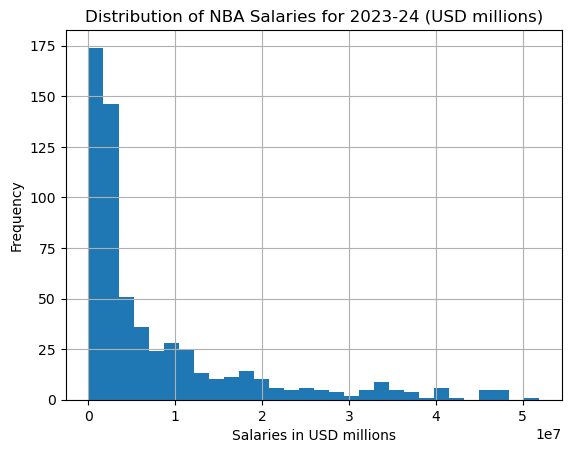

In [1465]:
df_salaries['Salary 2023/24'].hist(bins=30)
plt.title('Distribution of NBA Salaries for 2023-24 (USD millions)')
plt.xlabel('Salaries in USD millions')
plt.ylabel('Frequency')

## Data Preprocessing

In [1469]:
# Analyze function
def analyze(data):
    # Display the DataFrame
    display(data)

    # Print DataFrame Info
    print("DATAFRAME INFO:")
    data.info()
    print()

    # Calculate Percentage of Null Values
    print("PERCENTAGE OF NULL VALUES:")
    print((data.isnull().sum()/len(data)) * 100)
    print()

    # Calculate Number of Duplicated Rows
    print("NUMBER OF DUPLICATED ROWS:", data.duplicated().sum())

In [1470]:
analyze(df)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,...,0.616,2.6,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6
1,1,Precious Achiuwa,C,24,TOR,25,0,17.5,3.1,6.8,...,0.571,2.0,3.4,5.4,1.8,0.6,0.5,1.2,1.6,7.7
2,1,Precious Achiuwa,PF,24,NYK,49,18,24.2,3.2,6.1,...,0.643,2.9,4.3,7.2,1.1,0.6,1.1,1.1,2.1,7.6
3,2,Bam Adebayo,C,26,MIA,71,71,34.0,7.5,14.3,...,0.755,2.2,8.1,10.4,3.9,1.1,0.9,2.3,2.2,19.3
4,3,Ochai Agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,...,0.661,0.9,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730,568,Thaddeus Young,PF,35,PHO,10,0,8.9,1.1,2.1,...,0.333,1.7,1.1,2.8,0.7,0.5,0.2,0.4,1.1,2.3
731,569,Trae Young,PG,25,ATL,54,54,36.0,8.0,18.7,...,0.855,0.4,2.3,2.8,10.8,1.3,0.2,4.4,2.0,25.7
732,570,Omer Yurtseven,C,25,UTA,48,12,11.4,2.1,3.8,...,0.679,1.5,2.8,4.3,0.6,0.2,0.4,0.8,1.1,4.6
733,571,Cody Zeller,C,31,NOP,43,0,7.4,0.6,1.4,...,0.605,1.1,1.5,2.6,0.9,0.2,0.1,0.4,1.0,1.8


DATAFRAME INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      735 non-null    int64  
 1   Player  735 non-null    object 
 2   Pos     735 non-null    object 
 3   Age     735 non-null    int64  
 4   Tm      735 non-null    object 
 5   G       735 non-null    int64  
 6   GS      735 non-null    int64  
 7   MP      735 non-null    float64
 8   FG      735 non-null    float64
 9   FGA     735 non-null    float64
 10  FG%     735 non-null    float64
 11  3P      735 non-null    float64
 12  3PA     735 non-null    float64
 13  3P%     735 non-null    float64
 14  2P      735 non-null    float64
 15  2PA     735 non-null    float64
 16  2P%     735 non-null    float64
 17  eFG%    735 non-null    float64
 18  FT      735 non-null    float64
 19  FTA     735 non-null    float64
 20  FT%     735 non-null    float64
 21  ORB     735 non-null   

In [1471]:
for col in df.columns:
    print(df[col].value_counts(ascending=False).head())

Rk
367    4
563    4
303    4
295    4
162    4
Name: count, dtype: int64
Player
Mike Muscala          4
Dylan Windler         4
Kenneth Lofton Jr.    4
Kira Lewis Jr.        4
Danilo Gallinari      4
Name: count, dtype: int64
Pos
SF    155
SG    154
PF    147
PG    147
C     119
Name: count, dtype: int64
Age
24    94
25    82
23    72
26    57
22    56
Name: count, dtype: int64
Tm
TOT    78
MEM    33
DET    31
TOR    30
PHI    28
Name: count, dtype: int64
G
68    18
6     18
3     16
4     16
2     16
Name: count, dtype: int64
GS
0    253
1     49
2     24
3     20
5     18
Name: count, dtype: int64
MP
3.0     9
13.0    8
3.7     7
17.2    7
19.8    7
Name: count, dtype: int64
FG
1.5    29
0.6    21
2.6    21
2.0    21
1.7    20
Name: count, dtype: int64
FGA
3.5    16
1.0    15
3.3    15
3.7    14
4.9    13
Name: count, dtype: int64
FG%
0.500    19
0.000    19
0.400    11
0.443     9
0.446     9
Name: count, dtype: int64
3P
0.0    114
0.1     49
0.4     45
0.3     40
0.8     39
Name: 

In [1472]:
print(df['Player'].nunique())

572


Out of a dataset of 735 entries, only 572 have unique names. This is likely due to NBA trades per season during which teams exchange team members. In such cases, we may have data on say three-throw shots for a new team that might be more or less than one team because of different amounts of games played.

In [1474]:
df[df['Player'].isin(df['Player'].value_counts()[df['Player'].value_counts() > 1].index)]

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,...,0.616,2.6,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6
1,1,Precious Achiuwa,C,24,TOR,25,0,17.5,3.1,6.8,...,0.571,2.0,3.4,5.4,1.8,0.6,0.5,1.2,1.6,7.7
2,1,Precious Achiuwa,PF,24,NYK,49,18,24.2,3.2,6.1,...,0.643,2.9,4.3,7.2,1.1,0.6,1.1,1.1,2.1,7.6
4,3,Ochai Agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,...,0.661,0.9,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8
5,3,Ochai Agbaji,SG,23,UTA,51,10,19.7,2.1,4.9,...,0.750,0.7,1.8,2.5,0.9,0.5,0.6,0.7,1.3,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,567,Delon Wright,PG,31,WAS,33,0,13.8,1.5,3.7,...,0.828,0.4,1.4,1.8,2.5,1.1,0.2,0.3,0.7,4.1
727,567,Delon Wright,PG,31,MIA,14,1,20.4,1.9,4.7,...,0.813,0.4,1.5,1.9,2.6,1.4,0.2,0.2,0.7,5.4
728,568,Thaddeus Young,PF,35,TOT,33,6,13.3,2.0,3.3,...,0.400,1.4,1.7,3.1,1.7,0.7,0.2,0.5,1.5,4.2
729,568,Thaddeus Young,PF,35,TOR,23,6,15.2,2.3,3.8,...,0.417,1.3,2.0,3.3,2.2,0.8,0.1,0.5,1.7,5.0


Trades represent 32.7891% of the dataset.

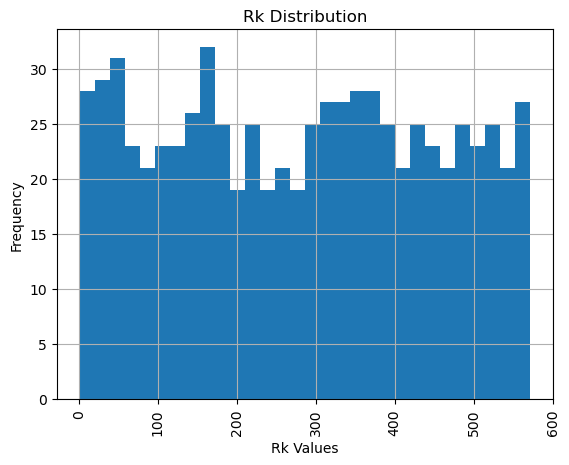

<Figure size 1000x600 with 0 Axes>

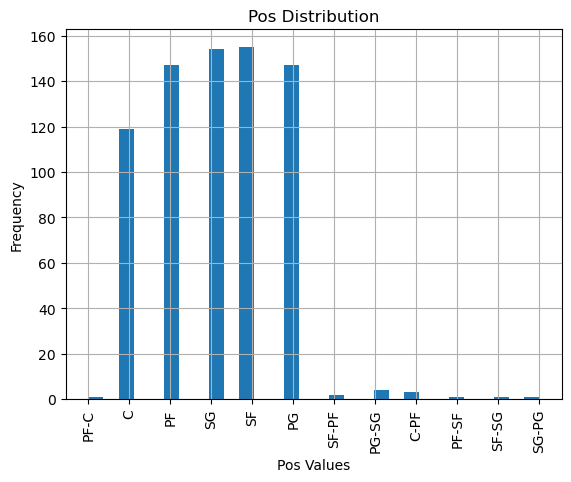

<Figure size 1000x600 with 0 Axes>

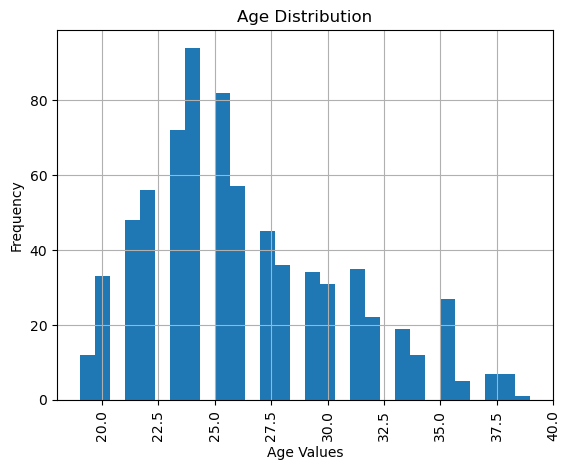

<Figure size 1000x600 with 0 Axes>

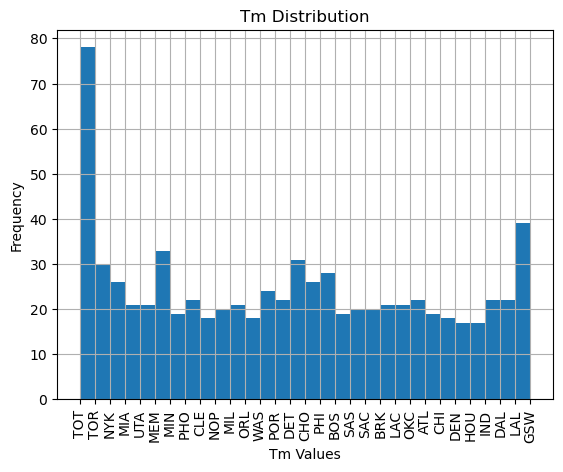

<Figure size 1000x600 with 0 Axes>

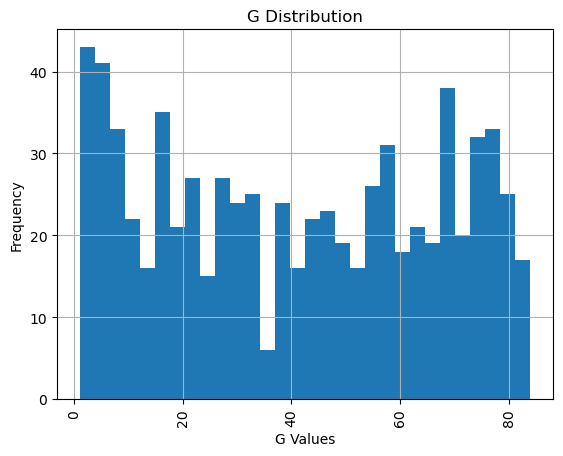

<Figure size 1000x600 with 0 Axes>

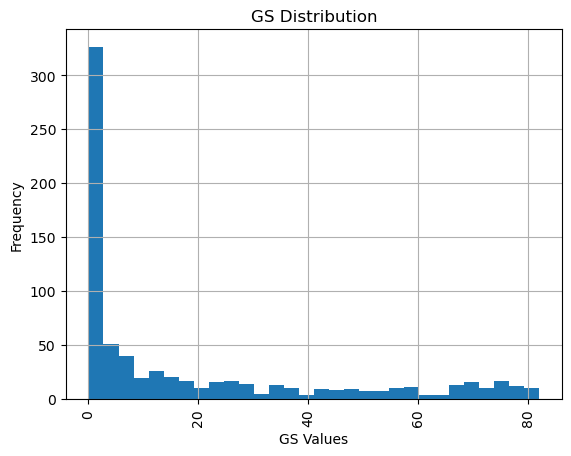

<Figure size 1000x600 with 0 Axes>

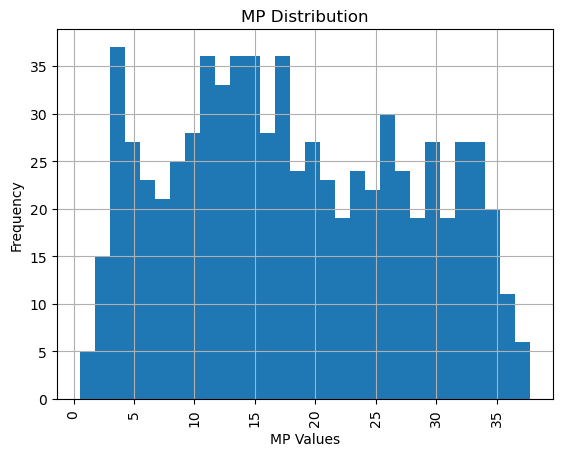

<Figure size 1000x600 with 0 Axes>

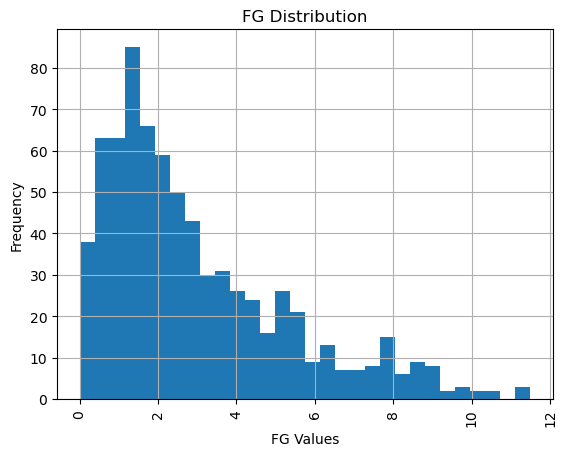

<Figure size 1000x600 with 0 Axes>

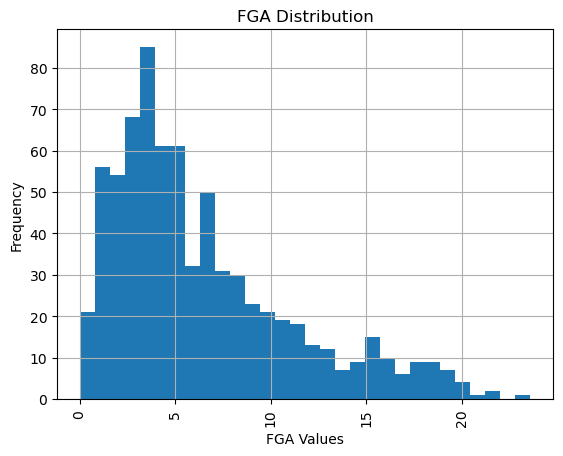

<Figure size 1000x600 with 0 Axes>

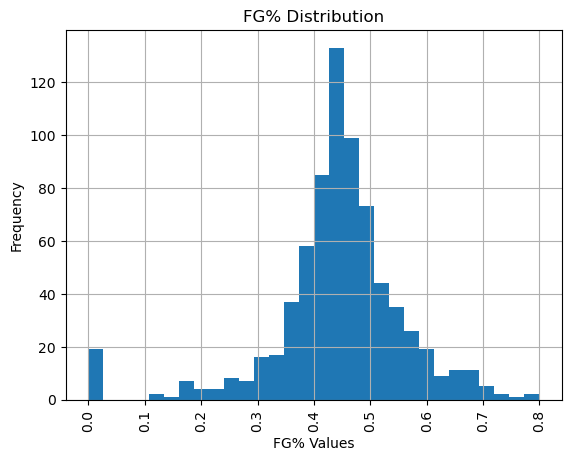

<Figure size 1000x600 with 0 Axes>

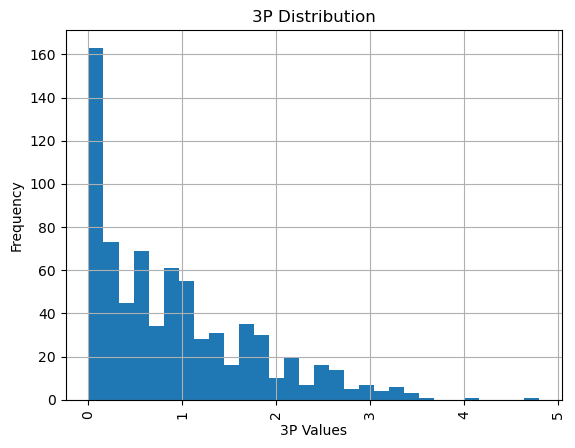

<Figure size 1000x600 with 0 Axes>

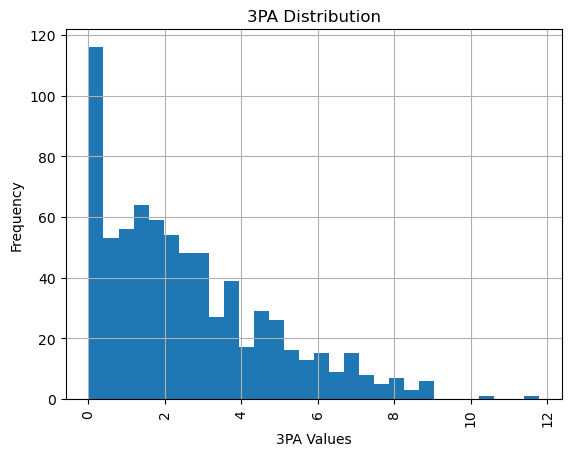

<Figure size 1000x600 with 0 Axes>

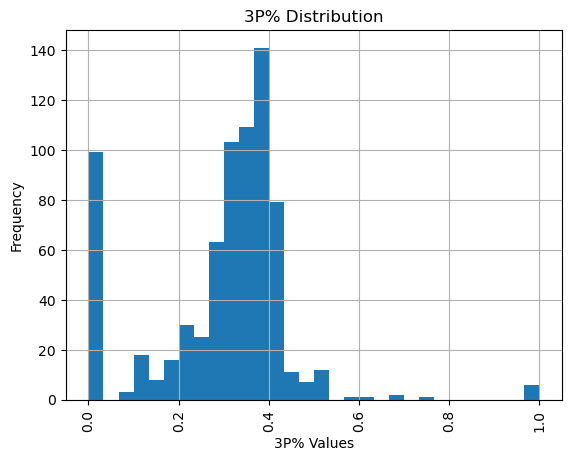

<Figure size 1000x600 with 0 Axes>

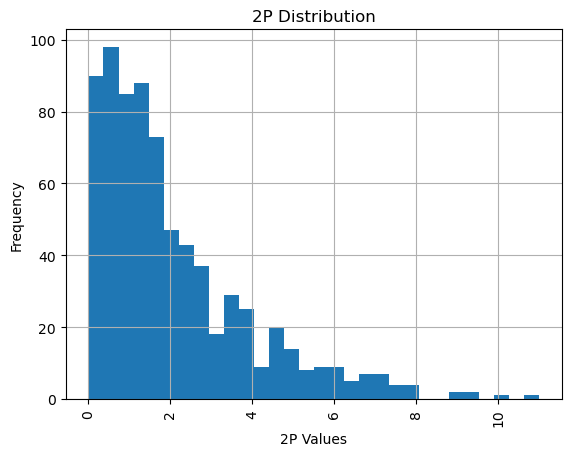

<Figure size 1000x600 with 0 Axes>

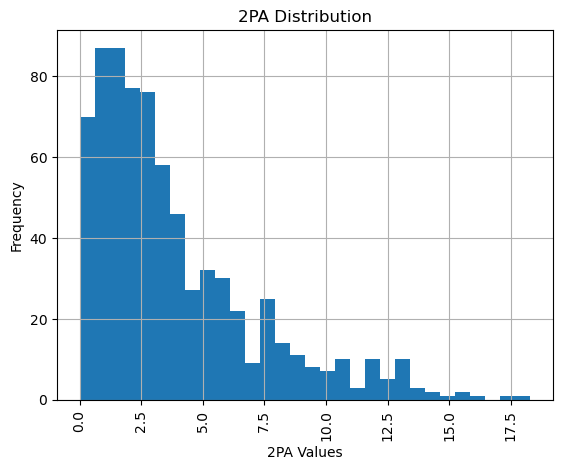

<Figure size 1000x600 with 0 Axes>

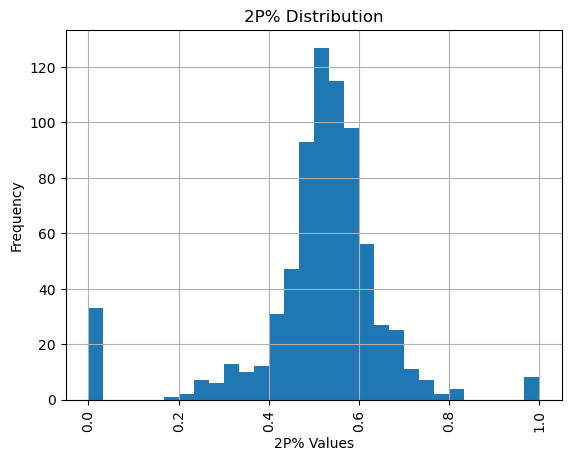

<Figure size 1000x600 with 0 Axes>

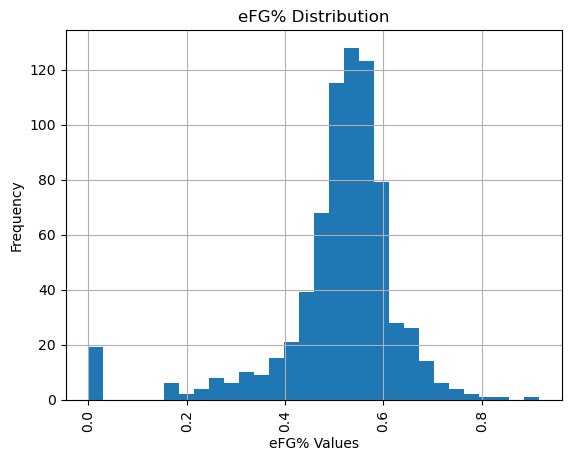

<Figure size 1000x600 with 0 Axes>

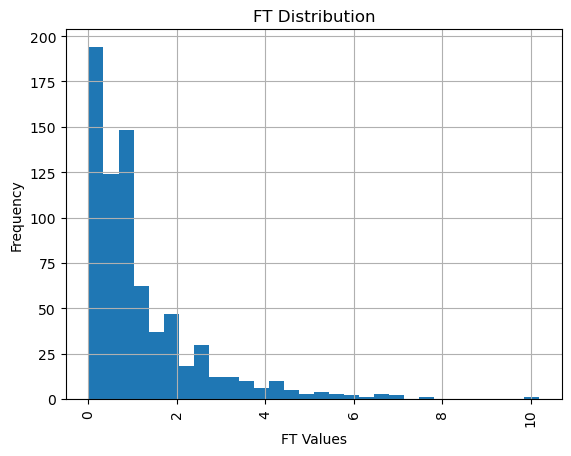

<Figure size 1000x600 with 0 Axes>

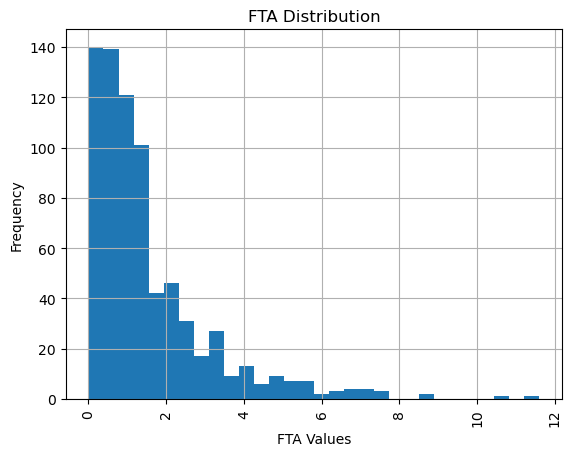

<Figure size 1000x600 with 0 Axes>

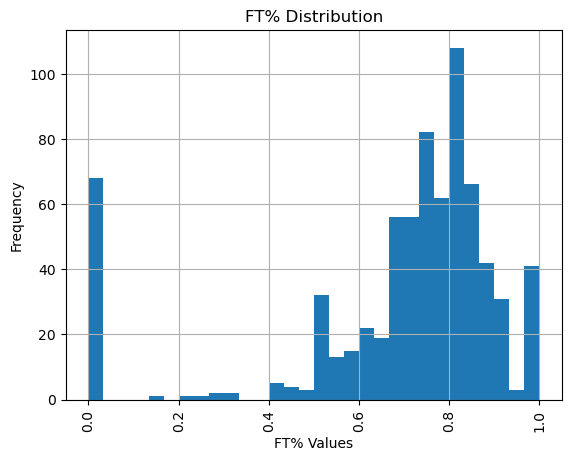

<Figure size 1000x600 with 0 Axes>

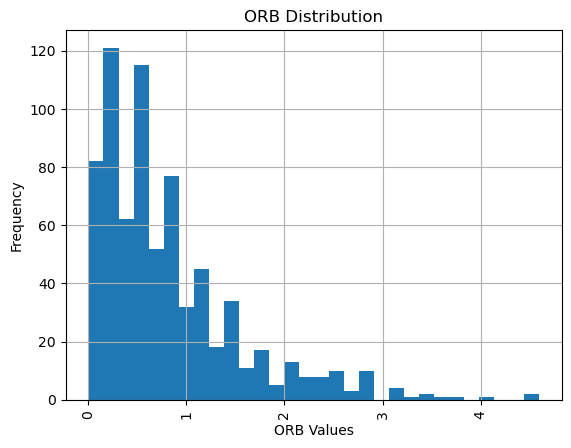

<Figure size 1000x600 with 0 Axes>

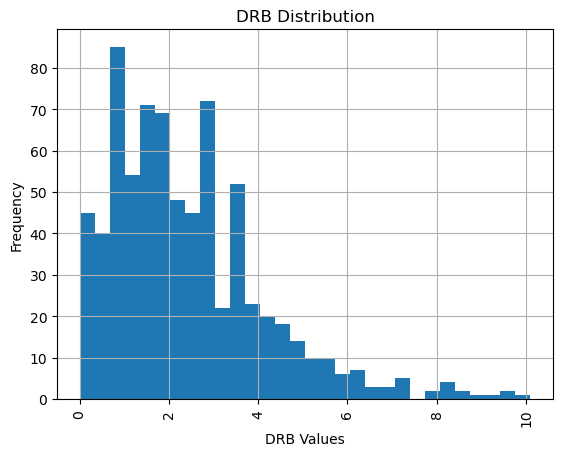

<Figure size 1000x600 with 0 Axes>

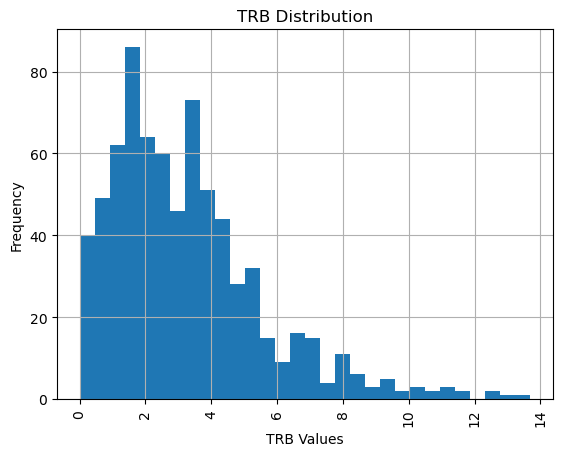

<Figure size 1000x600 with 0 Axes>

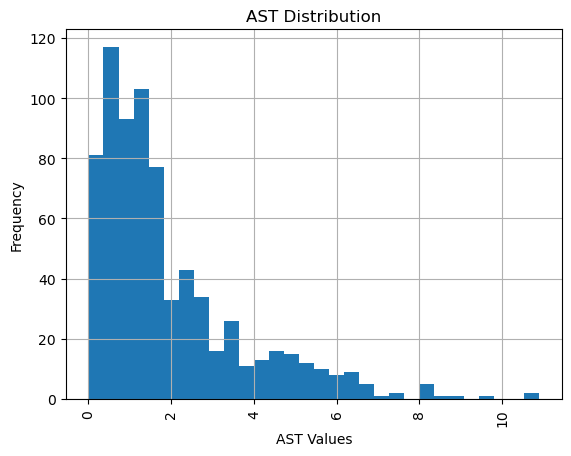

<Figure size 1000x600 with 0 Axes>

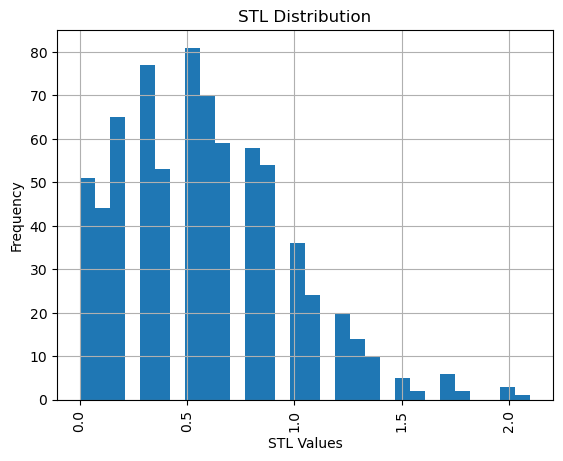

<Figure size 1000x600 with 0 Axes>

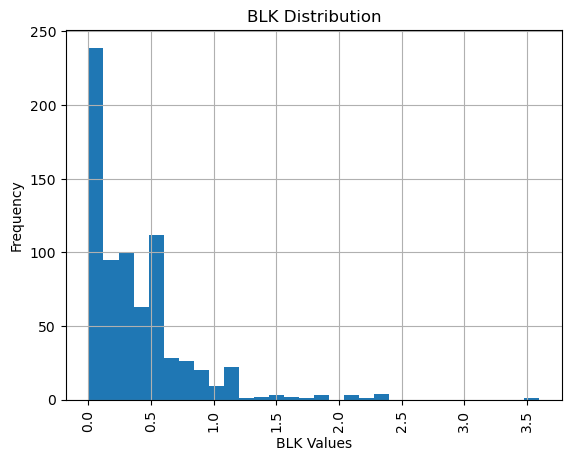

<Figure size 1000x600 with 0 Axes>

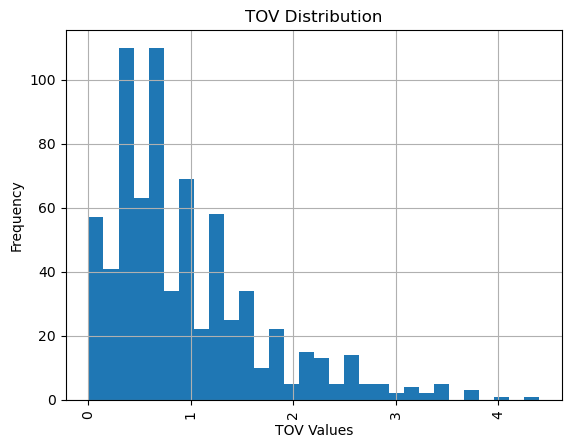

<Figure size 1000x600 with 0 Axes>

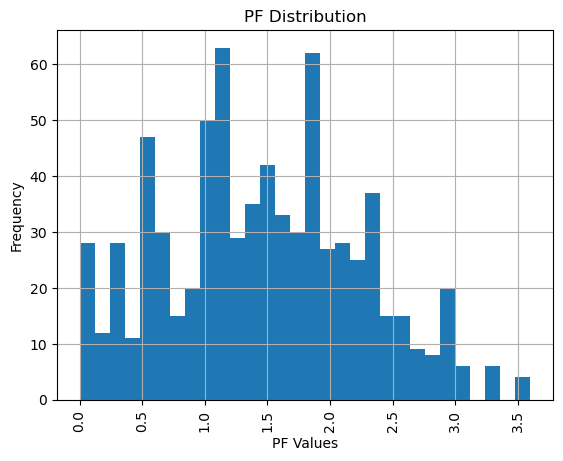

<Figure size 1000x600 with 0 Axes>

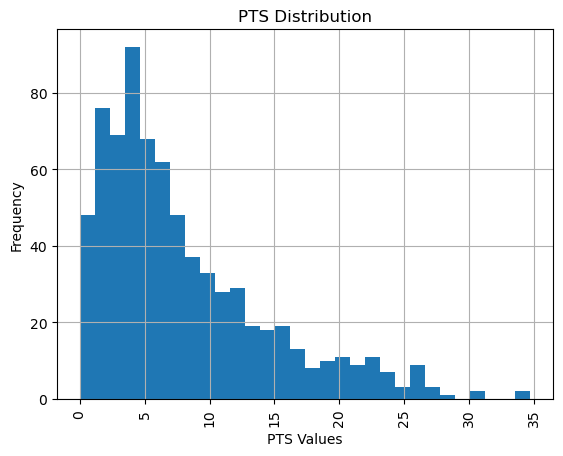

<Figure size 1000x600 with 0 Axes>

In [1476]:
for col in df.columns.drop('Player'):
    df[col].hist(bins=30)
    plt.ylabel('Frequency')
    plt.xlabel(f'{col} Values')
    plt.xticks(rotation=90)
    plt.title(f'{col} Distribution')
    plt.figure(figsize=(10, 6))  # Optional: adjust figure size
    plt.tight_layout()
    plt.show()

Histograms provide some initial data exploration.

### Anomaly Detection

In [1479]:
from pyod.models.knn import KNN
from sklearn.ensemble import IsolationForest

data = df.copy()
data = data.drop(columns=['Player', 'Tm', 'Pos'])

model_knn = KNN()
model_knn.fit(data) 

predictions_knn = model_knn.predict(data)  # Use predict instead of fit_predict
result_knn = predictions_knn == 1
outliers_knn = result_knn.sum()
print('Number of anomalies (KNN): ', outliers_knn)

model_iforest = IsolationForest(n_estimators=100)
model_iforest.fit(data)  

predictions_iforest = model_iforest.predict(data) == -1  
outliers_iforest = predictions_iforest.sum()
print('Number of anomalies (Isolation Forest): ', outliers_iforest)

print('Matched: ', (estimation_knn & estimation_iforest).sum())

df_clean = df.copy()
mask = ~(estimation_knn & estimation_iforest)
df_clean = df[mask]

df_clean.info()
df = df_clean.copy()

Number of anomalies (KNN):  39
Number of anomalies (Isolation Forest):  103
Matched:  29
<class 'pandas.core.frame.DataFrame'>
Index: 706 entries, 0 to 733
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Rk      706 non-null    int64  
 1   Player  706 non-null    object 
 2   Pos     706 non-null    object 
 3   Age     706 non-null    int64  
 4   Tm      706 non-null    object 
 5   G       706 non-null    int64  
 6   GS      706 non-null    int64  
 7   MP      706 non-null    float64
 8   FG      706 non-null    float64
 9   FGA     706 non-null    float64
 10  FG%     706 non-null    float64
 11  3P      706 non-null    float64
 12  3PA     706 non-null    float64
 13  3P%     706 non-null    float64
 14  2P      706 non-null    float64
 15  2PA     706 non-null    float64
 16  2P%     706 non-null    float64
 17  eFG%    706 non-null    float64
 18  FT      706 non-null    float64
 19  FTA     706 non-null    float

IsolatedForest and KNN provides anomaly detection for high dimensionality dataset. I drop these anomalies from the original dataframe and resave df.

In [1481]:
# Define the mapping of current column names to full names
column_mapping = {
    'Rk': 'Rank',
    'Player': 'Player Name',
    'Pos': 'Position',
    'Age': 'Age',
    'Tm': 'Team',
    'G': 'Games Played',
    'GS': 'Games Started',
    'MP': 'Minutes Per Game',
    'FG': 'Field Goals Made',
    'FGA': 'Field Goals Attempted',
    'FG%': 'Field Goal Percentage',
    '3P': 'Three-Point Field Goals Made',
    '3PA': 'Three-Point Field Goals Attempted',
    '3P%': 'Three-Point Field Goal Percentage',
    '2P': 'Two-Point Field Goals Made',
    '2PA': 'Two-Point Field Goals Attempted',
    '2P%': 'Two-Point Field Goal Percentage',
    'eFG%': 'Effective Field Goal Percentage',
    'FT': 'Free Throws Made',
    'FTA': 'Free Throws Attempted',
    'FT%': 'Free Throw Percentage',
    'ORB': 'Offensive Rebounds',
    'DRB': 'Defensive Rebounds',
    'TRB': 'Total Rebounds',
    'AST': 'Assists',
    'STL': 'Steals',
    'BLK': 'Blocks',
    'TOV': 'Turnovers',
    'PF': 'Personal Fouls',
    'PTS': 'Points'
}

# Rename the columns using the mapping
df.rename(columns=column_mapping, inplace=True)

In [1483]:
df_original = df.copy()
df = df.drop(columns=['Age', 
                      'Rank', 
                    #  'Position', 
                      'Team',
                      'Games Played',
                      'Games Started',
                      'Field Goal Percentage',
                      'Three-Point Field Goal Percentage', 
                      'Two-Point Field Goal Percentage', 
                      'Effective Field Goal Percentage',
                      'Free Throw Percentage', 
                      'Total Rebounds'
                      ])

1) Rank ('Rk'): This is just an identifier of player rank and does not represent a player's performance, so it does not contribute to clustering.
2) Player Name ('Player'): This is also an identifier, not a numeric or performance-related feature.
3) Age ('Age'): While age can influence a player's style, it may not directly contribute to player archetypes like playing style or efficiency. If you want to account for experience or prime age, you could consider including it. More data might suggest how players' roles or achetypes change with time.
4) Team ('Tm'): Teams influence player performance but may not help identify archetypes unless you want to include team-based playing styles. You can drop this feature unless team context is crucial for the clustering.
5) Games Played ('G'): If the dataset already has a substantial number of games for each player, this might be redundant, as you may already have performance metrics (e.g., minutes played, points) that reflect their impact on the court.
6) Games Started ('GS'): Similar to 'Games Played,' this feature may not add unique information when compared to other features like 'Minutes Per Game' or 'Points'.
7) Field Goal Percentage ('FG%') and Effective Field Goal Percentage ('eFG%'): If you're using other shooting stats like 'Field Goals Made', '3P%', and '2P%', you might not need these, as they can be highly correlated.

In [1486]:
aggregated_df = df.groupby('Player Name').agg({
    #'Age': 'first',  # Use the first occurrence of age, assuming age doesn’t change within a season
    #'Games Played': 'sum',  # Total games played
    #'Games Started': 'sum',  # Total games started
    'Minutes Per Game': 'sum',  # Total minutes played
    'Field Goals Made': 'sum',  # Total field goals made
    'Field Goals Attempted': 'sum',  # Total field goals attempted
    #'Field Goal Percentage': 'mean',
    'Three-Point Field Goals Made': 'sum',  # Total three-pointers made
    'Three-Point Field Goals Attempted': 'sum',  # Total three-point attempts
    #'Three-Point Field Goal Percentage': 'mean',
    'Two-Point Field Goals Made': 'sum',  # Total two-pointers made
    'Two-Point Field Goals Attempted': 'sum',  # Total two-point attempts
    #'Two-Point Field Goal Percentage': 'mean',
    #'Effective Field Goal Percentage': 'mean',
    'Free Throws Made': 'sum',  # Total free throws made
    'Free Throws Attempted': 'sum',  # Total free throw attempts
    #'Free Throw Percentage': 'mean',
    'Offensive Rebounds': 'sum',  # Total offensive rebounds
    'Defensive Rebounds': 'sum',  # Total defensive rebounds
    #'Total Rebounds': 'sum',  # Total rebounds
    'Assists': 'sum',  # Total assists
    'Steals': 'sum',  # Total steals
    'Blocks': 'sum',  # Total blocks
    'Turnovers': 'sum',  # Total turnovers
    'Personal Fouls': 'sum',  # Total personal fouls
    'Points': 'sum'   # Total points scored
}).reset_index()

# Verify the aggregated data
aggregated_df

,Player Name,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points
0,A.J. Green,11.0,1.5,3.5,1.2,3.0,0.3,0.5,0.3,0.3,0.2,1.0,0.5,0.2,0.1,0.2,0.9,4.5
1,A.J. Lawson,7.4,1.3,2.9,0.3,1.2,1.0,1.7,0.4,0.5,0.3,0.9,0.5,0.2,0.1,0.3,0.5,3.2
2,AJ Griffin,8.6,0.9,3.1,0.5,2.0,0.4,1.2,0.1,0.1,0.1,0.8,0.3,0.1,0.1,0.4,0.3,2.4
3,Aaron Gordon,31.5,5.5,9.8,0.5,1.9,4.9,7.9,2.4,3.7,2.4,4.1,3.5,0.8,0.6,1.4,1.9,13.9
4,Aaron Holiday,16.3,2.4,5.3,1.1,2.8,1.3,2.6,0.7,0.8,0.3,1.3,1.8,0.5,0.1,0.7,1.6,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,Zach LaVine,34.9,6.8,15.0,2.4,6.8,4.4,8.3,3.5,4.1,0.3,4.8,3.9,0.8,0.3,2.1,2.3,19.5
540,Zavier Simpson,23.0,2.4,7.7,0.7,2.4,1.7,5.3,0.4,0.6,0.6,2.3,3.6,1.0,0.4,1.4,1.6,6.0
541,Zeke Nnaji,9.9,1.2,2.6,0.1,0.4,1.1,2.2,0.7,1.1,1.1,1.1,0.6,0.3,0.7,0.5,1.4,3.2
542,Ziaire Williams,20.4,2.9,7.4,1.1,3.7,1.8,3.7,1.2,1.5,0.7,2.8,1.5,0.7,0.2,1.3,1.7,8.2


### Encoding

In [1489]:
names = aggregated_df['Player Name']
aggregated_df = aggregated_df.drop(columns='Player Name')

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the DataFrame
scaled_df = pd.DataFrame(scaler.fit_transform(aggregated_df), columns=aggregated_df.columns)
scaled_df

,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points
0,-0.690321,-0.647939,-0.633083,0.039841,-0.083371,-0.877569,-0.913490,-0.682334,-0.755854,-0.808882,-0.803531,-0.741903,-0.831210,-0.720330,-0.904931,-0.680098,-0.589612
1,-0.897866,-0.709107,-0.719279,-0.688002,-0.632007,-0.593959,-0.648232,-0.619174,-0.653962,-0.709237,-0.844544,-0.741903,-0.831210,-0.720330,-0.809620,-0.969309,-0.735214
2,-0.828685,-0.831443,-0.690547,-0.526259,-0.388169,-0.837054,-0.758756,-0.808653,-0.857746,-0.908527,-0.885558,-0.822133,-0.985695,-0.720330,-0.714309,-1.113915,-0.824814
3,0.491530,0.575415,0.271978,-0.526259,-0.418648,0.986158,0.722267,0.644020,0.976308,1.383305,0.467885,0.461542,0.095701,0.248660,0.238804,0.042930,0.463199
4,-0.384769,-0.372685,-0.374494,-0.041030,-0.144331,-0.472411,-0.449289,-0.429695,-0.501124,-0.709237,-0.680491,-0.220410,-0.367754,-0.720330,-0.428375,-0.173979,-0.354410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,0.687545,0.973005,1.019012,1.010299,1.074860,0.783579,0.810687,1.338777,1.180092,-0.709237,0.754978,0.622001,0.095701,-0.332734,0.905982,0.332141,1.090405
540,0.001494,-0.372685,-0.029709,-0.364516,-0.266250,-0.310348,0.147542,-0.619174,-0.603016,-0.410302,-0.270357,0.501657,0.404672,-0.138936,0.238804,-0.173979,-0.421610
541,-0.753738,-0.739691,-0.762378,-0.849745,-0.875845,-0.553443,-0.537708,-0.429695,-0.348287,0.087922,-0.762518,-0.701789,-0.676725,0.442458,-0.618997,-0.318584,-0.735214
542,-0.148399,-0.219765,-0.072807,-0.041030,0.129987,-0.269832,-0.206136,-0.113896,-0.144503,-0.310657,-0.065290,-0.340755,-0.058784,-0.526532,0.143492,-0.101676,-0.175208


## EDA

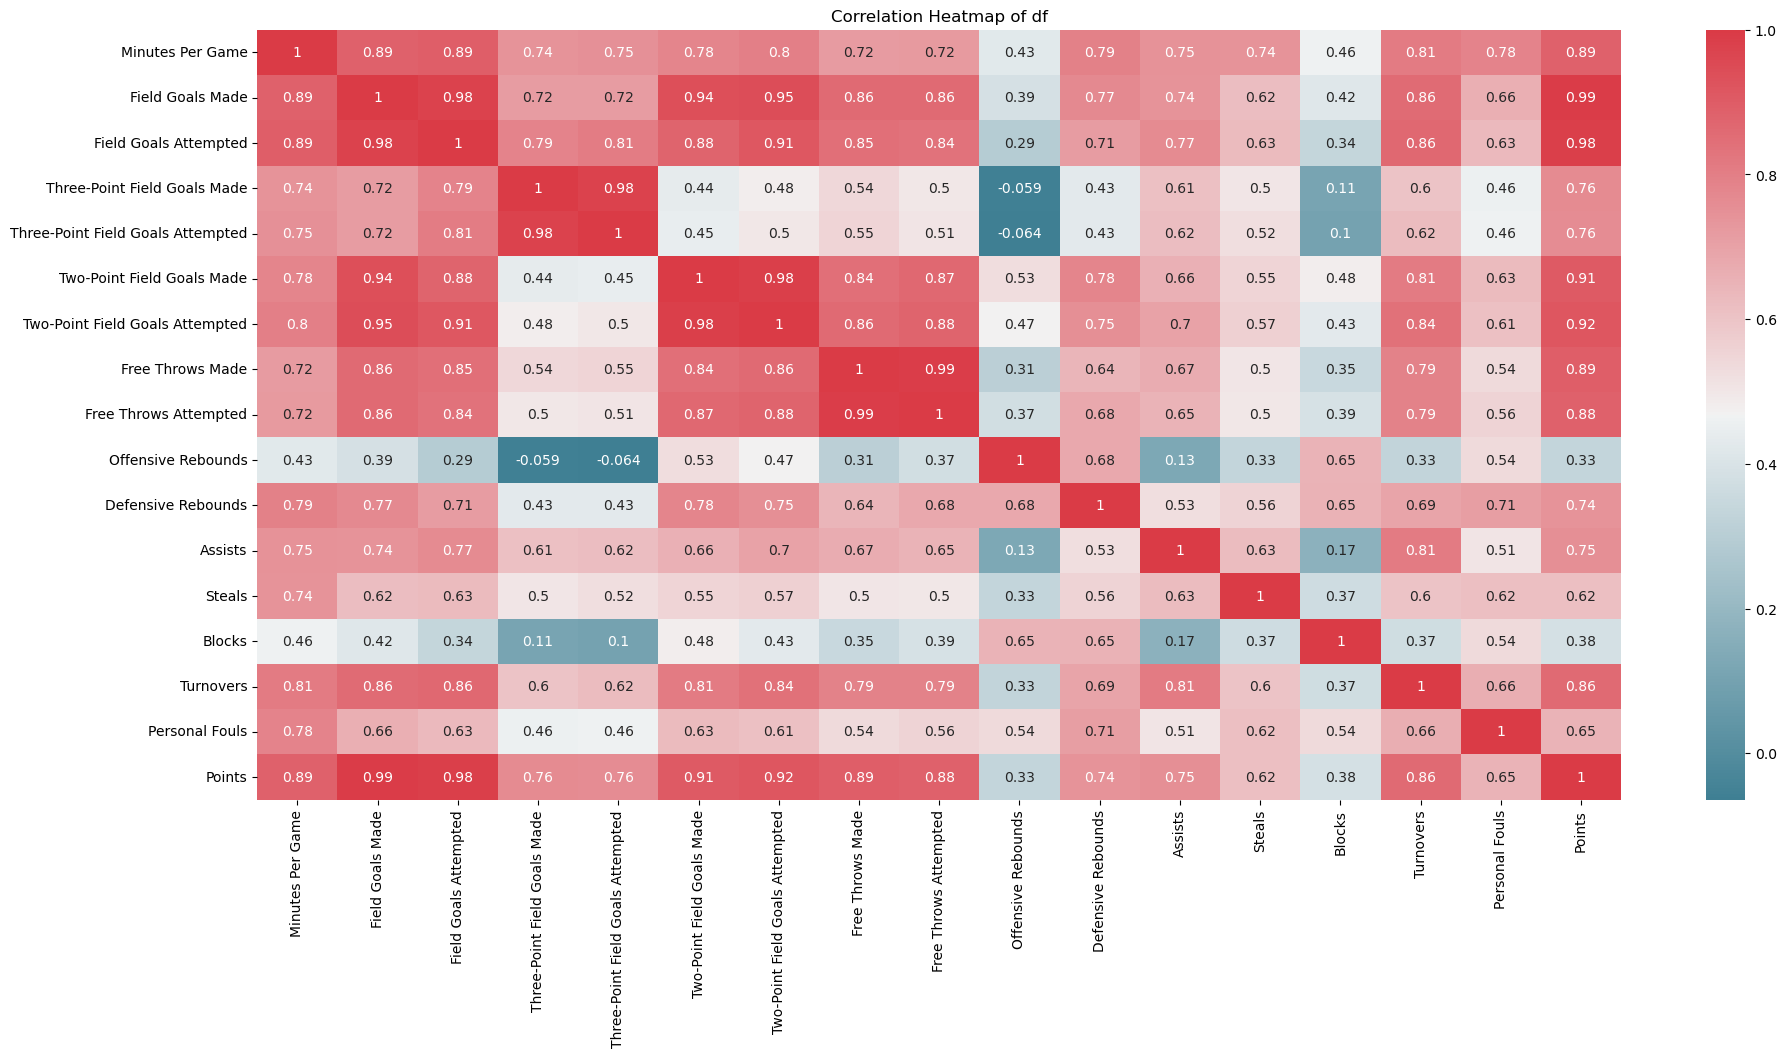

In [1491]:
numerical_columns = df.select_dtypes(include=[np.number])
corr = numerical_columns.corr()
plt.figure(figsize=(22, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)
plt.title(label='Correlation Heatmap of df')
plt.show()

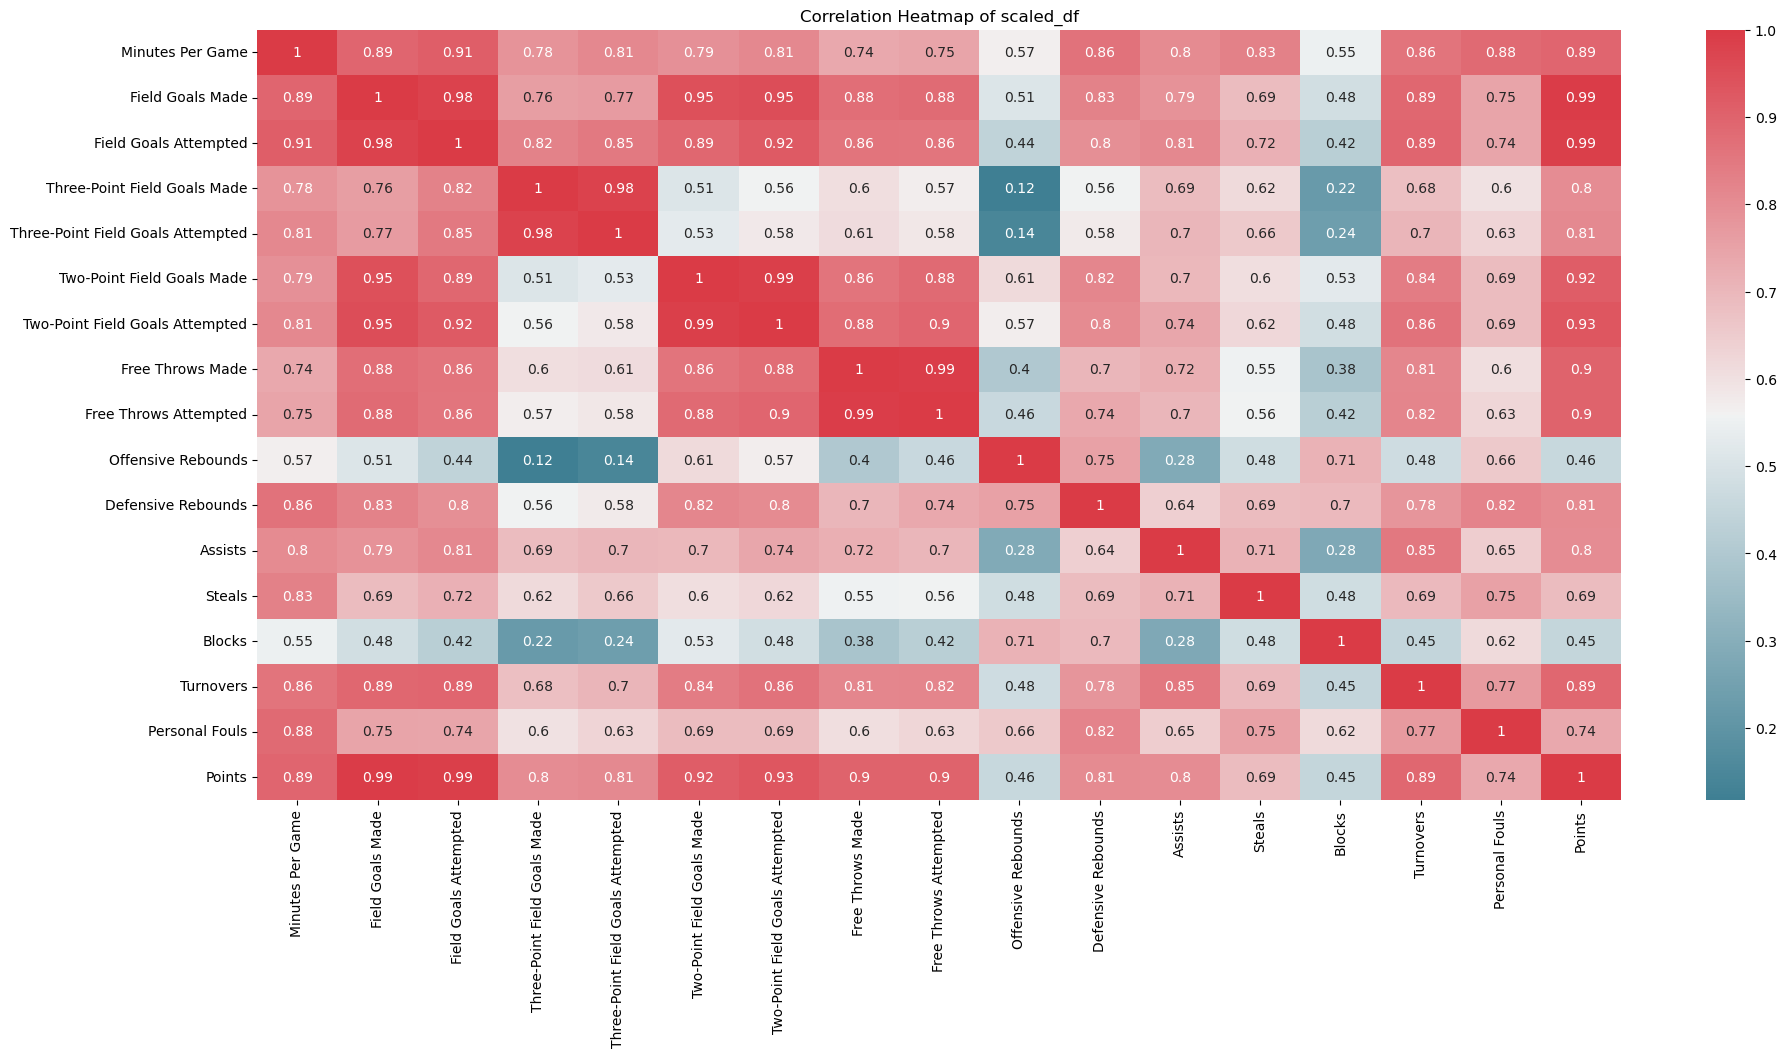

In [1492]:
numerical_columns = scaled_df.select_dtypes(include=[np.number])
corr = numerical_columns.corr()
plt.figure(figsize=(22, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)
plt.title(label='Correlation Heatmap of scaled_df')
plt.show()

In [1493]:
print(scaled_df.shape)
df.shape

(544, 17)


(706, 19)

There are many fields with high correlations which should help us reduce the dimensionality of this dataset before model building. Correlations between the dataframe df and scaled_df are slightly different in some cells. This is likely due to the reduction of data that comes from aggregating the performance of unique players across different teams. There are some players who play on four different teams in the course of the 2023-24 season.

## PCA

- Original data had 30 features
- Used principal component analysis to reduce that down to 6 components
- Chose 6 because it retained 96% of the information but still significantly reduced down dimensions
- Retaining 95% of the information was the goal

For n_components = 2, explained variance ratio is 0.8360245347768548
For n_components = 3, explained variance ratio is 0.9005917871556197
For n_components = 4, explained variance ratio is 0.9282819089134539
For n_components = 5, explained variance ratio is 0.9462442894791658
For n_components = 6, explained variance ratio is 0.9605131317945432
For n_components = 7, explained variance ratio is 0.9741021489146797
For n_components = 8, explained variance ratio is 0.9833374926352316
For n_components = 9, explained variance ratio is 0.9897762186305743
For n_components = 10, explained variance ratio is 0.9952840633906389
For n_components = 11, explained variance ratio is 0.997643939433114
For n_components = 12, explained variance ratio is 0.9990507203790386
For n_components = 13, explained variance ratio is 0.9996123173612137
For n_components = 14, explained variance ratio is 0.9999840050032596
For n_components = 15, explained variance ratio is 0.9999951740167297
For n_components = 16, explai

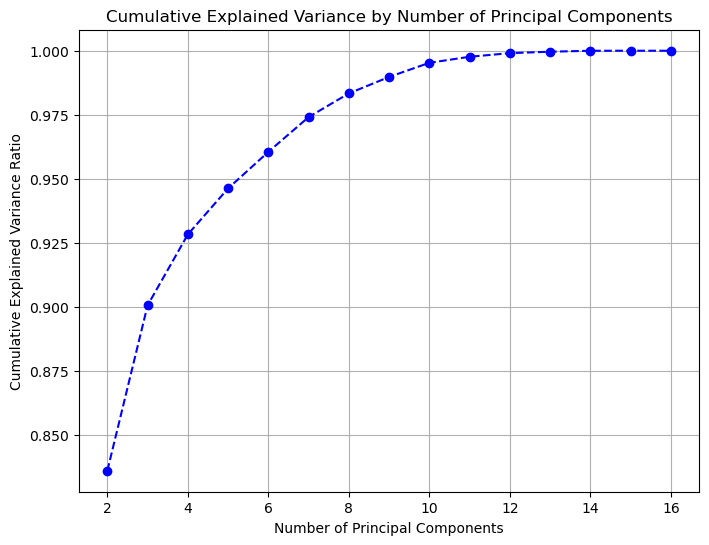

In [1496]:
variance_list = []

for n_components in range(2,17):
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(scaled_df)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print("For n_components = {}, explained variance ratio is {}".format(n_components, variance))

plt.figure(figsize=(8, 6))
plt.plot(range(2, 17), variance_list, marker='o', linestyle='--', color='b')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

For n_clusters = 2, silhouette score is 0.515644
For n_clusters = 3, silhouette score is 0.447706
For n_clusters = 4, silhouette score is 0.338127
For n_clusters = 5, silhouette score is 0.325181
For n_clusters = 6, silhouette score is 0.338517
For n_clusters = 7, silhouette score is 0.290345
For n_clusters = 8, silhouette score is 0.275662
For n_clusters = 9, silhouette score is 0.262775
For n_clusters = 10, silhouette score is 0.260848
For n_clusters = 11, silhouette score is 0.262081
For n_clusters = 12, silhouette score is 0.257388
For n_clusters = 13, silhouette score is 0.259945
For n_clusters = 14, silhouette score is 0.260046
For n_clusters = 15, silhouette score is 0.260190


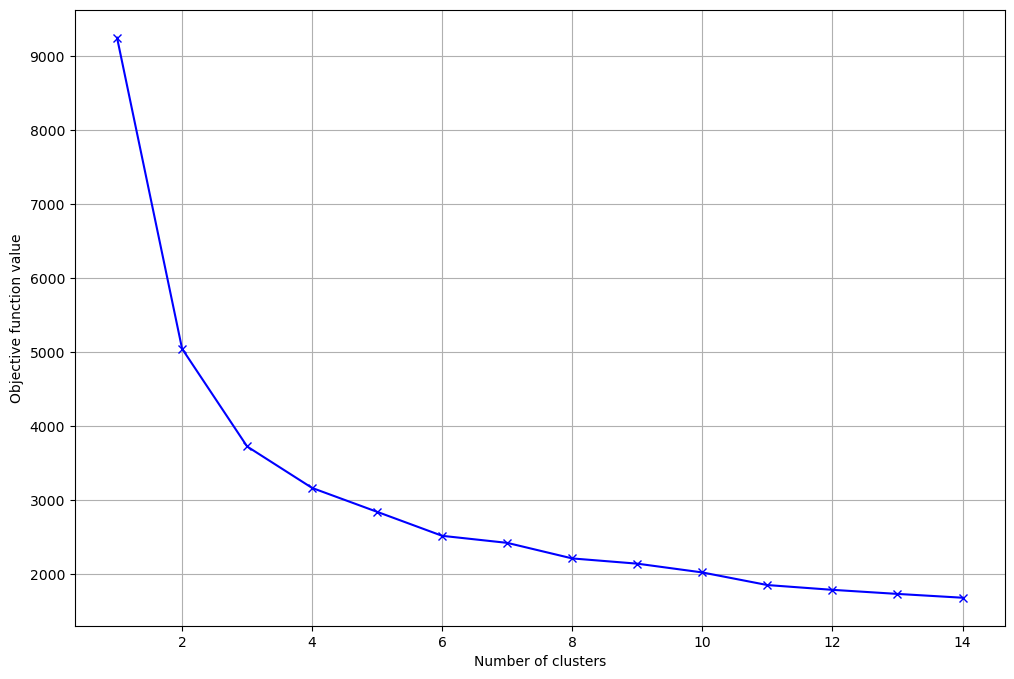

In [1497]:
# Perform PCA to reduce data to 6 components
pca_6 = PCA(n_components=6)
components_6 = pca_6.fit_transform(scaled_df)

# Initialize a list to store silhouette scores
silhouette_scores = []

# Range for the number of clusters
K = range(2, 16)  # Start from 2 because silhouette score is undefined for 1 cluster

# Calculate silhouette score for each value of K
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(components_6)
    score = silhouette_score(components_6, model.labels_)
    silhouette_scores.append(score)

    # Output the silhouette score for each k
    print(f"For n_clusters = {k}, silhouette score is {score:.6f}")


distortion = []
K = range(1, 15)
for k in K:
    model = KMeans(n_clusters=k, random_state=12345)
    model.fit(scaled_df)
    distortion.append(model.inertia_)

plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Objective function value')
plt.grid(True)
plt.show()


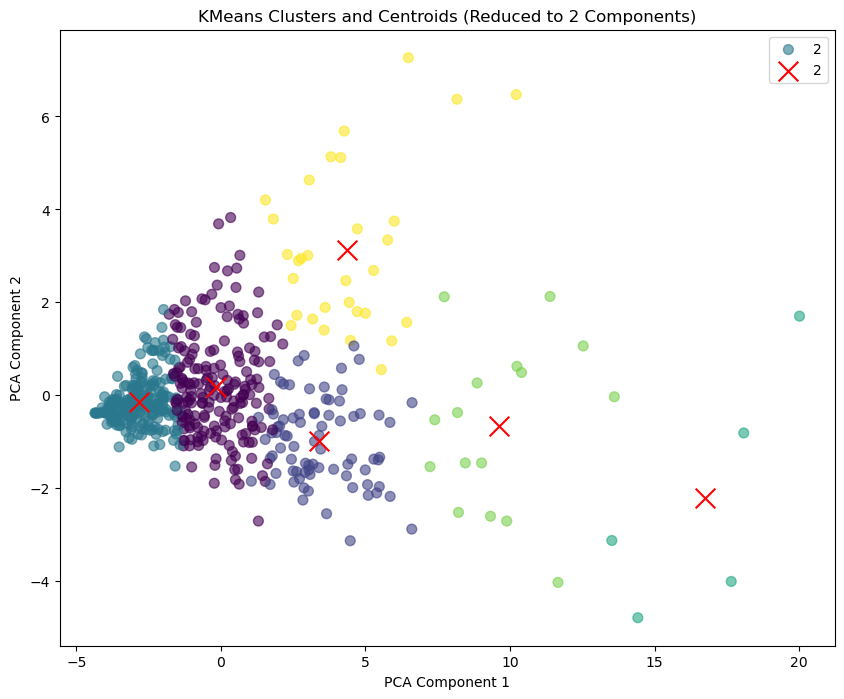

In [1498]:
# Perform PCA to reduce the data to 6 components
pca = PCA(n_components=6)
scaled_df_pca_6 = pca.fit_transform(scaled_df)

# Fit KMeans with 6 clusters
kmeans = KMeans(n_clusters=6, random_state=12345)
kmeans.fit(components_6)

# Reduce data to 2 components for visualization
pca_2d = PCA(n_components=2)
scaled_df_pca_2d = pca_2d.fit_transform(components_6)

# Get the cluster labels and centroids
labels = kmeans.labels_
centroids = pca_2d.transform(kmeans.cluster_centers_)

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(scaled_df_pca_2d[:, 0], scaled_df_pca_2d[:, 1], c=labels, cmap='viridis', alpha=0.6, s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')

# Add labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clusters and Centroids (Reduced to 2 Components)')
plt.legend(labels=labels)

# Show the plot
plt.show()

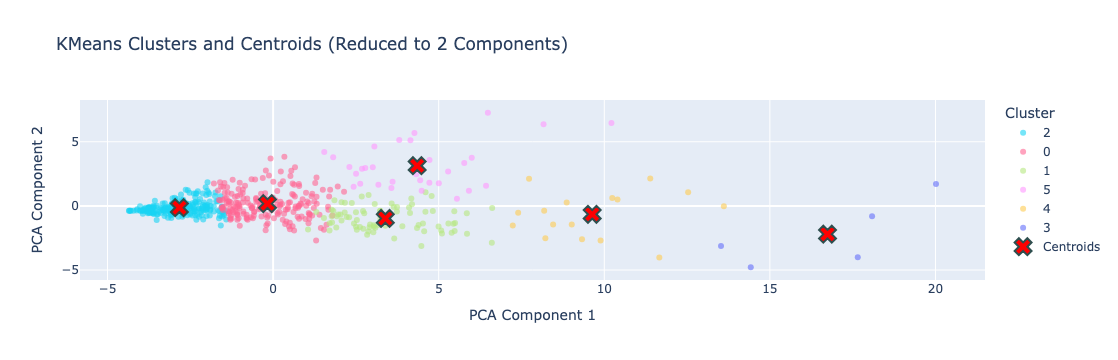

In [1499]:
df_pca = pd.DataFrame(scaled_df_pca_2d, columns=['PCA Component 1', 'PCA Component 2'])
df_pca['Cluster'] = labels.astype(str)  # Add cluster labels to the DataFrame

color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'purple'}
    
# Create the scatter plot using Plotly Express
fig = px.scatter(
        df_pca, 
        x='PCA Component 1', 
        y='PCA Component 2', 
        color='Cluster',  # Color by cluster labels
        color_discrete_map=color_map,  # Match the 'viridis' color scale
        opacity=0.6,  # Set transparency
        title='KMeans Clusters and Centroids (Reduced to 2 Components)',
        labels={'PCA Component 1': 'PCA Component 1', 'PCA Component 2': 'PCA Component 2'},
        template=None  # Optional: use a dark theme
    )

    # Add centroids to the plot as red 'x' markers
fig.add_scatter(
        x=centroids[:, 0], 
        y=centroids[:, 1], 
        mode='markers', 
        marker=dict(color='red', size=15, symbol='x', line=dict(width=2, color='DarkSlateGrey')),
        name='Centroids', 
        hoverinfo='text', 
        text=['Centroid'] * len(centroids)
)

    # Show the plot
fig.show()

We chose to go with six clusters for the dataset and thus 6 archetypes. These visualizations are useful but to reduce the data to two dimensions would eliminate half of the data's variance.

In [1501]:
aggregated_df['Player Name'] = names
aggregated_df['Archetype'] = labels

columns = ['Player Name', 'Archetype'] + [col for col in aggregated_df.columns if col not in ['Player Name', 'Archetype']]
aggregated_df = aggregated_df[columns]

# Display the updated DataFrame
display(aggregated_df)

,Player Name,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points
0,A.J. Green,2,11.0,1.5,3.5,1.2,3.0,0.3,0.5,0.3,0.3,0.2,1.0,0.5,0.2,0.1,0.2,0.9,4.5
1,A.J. Lawson,2,7.4,1.3,2.9,0.3,1.2,1.0,1.7,0.4,0.5,0.3,0.9,0.5,0.2,0.1,0.3,0.5,3.2
2,AJ Griffin,2,8.6,0.9,3.1,0.5,2.0,0.4,1.2,0.1,0.1,0.1,0.8,0.3,0.1,0.1,0.4,0.3,2.4
3,Aaron Gordon,0,31.5,5.5,9.8,0.5,1.9,4.9,7.9,2.4,3.7,2.4,4.1,3.5,0.8,0.6,1.4,1.9,13.9
4,Aaron Holiday,2,16.3,2.4,5.3,1.1,2.8,1.3,2.6,0.7,0.8,0.3,1.3,1.8,0.5,0.1,0.7,1.6,6.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,Zach LaVine,1,34.9,6.8,15.0,2.4,6.8,4.4,8.3,3.5,4.1,0.3,4.8,3.9,0.8,0.3,2.1,2.3,19.5
540,Zavier Simpson,0,23.0,2.4,7.7,0.7,2.4,1.7,5.3,0.4,0.6,0.6,2.3,3.6,1.0,0.4,1.4,1.6,6.0
541,Zeke Nnaji,2,9.9,1.2,2.6,0.1,0.4,1.1,2.2,0.7,1.1,1.1,1.1,0.6,0.3,0.7,0.5,1.4,3.2
542,Ziaire Williams,0,20.4,2.9,7.4,1.1,3.7,1.8,3.7,1.2,1.5,0.7,2.8,1.5,0.7,0.2,1.3,1.7,8.2


This may lead to a problem wherein a player plays a different position on different teams and thus exhibits different behaviors as a member of that team. This analysis takes that assumption for granted at the moment.

In [1503]:
df.loc[df['Player Name'].isin(df['Player Name'].value_counts()[df['Player Name'].value_counts() > 1].index)]['Position'].describe()

count     240
unique     12
top        PG
freq       61
Name: Position, dtype: object

Point Guards are the most often traded.

(240,)


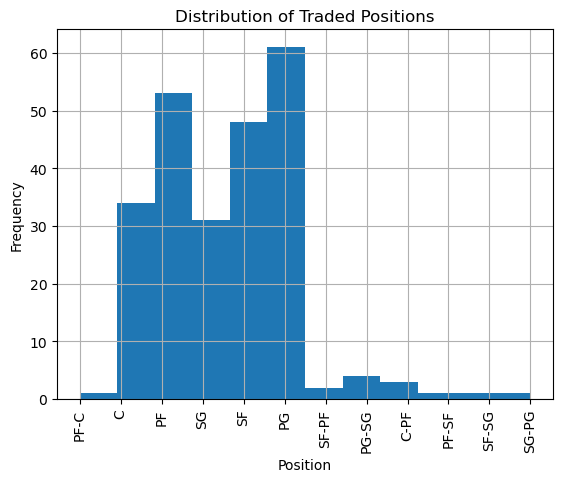

In [1505]:
df.loc[df['Player Name'].isin(df['Player Name'].value_counts()[df['Player Name'].value_counts() > 1].index)]['Position'].hist(bins=12)
print(df.loc[df['Player Name'].isin(df['Player Name'].value_counts()[df['Player Name'].value_counts() > 1].index)]['Position'].shape)
plt.xticks(rotation=90)
plt.xlabel('Position')
plt.ylabel('Frequency')
plt.title('Distribution of Traded Positions')
plt.show()

Text(0.5, 0, 'Number of Positions Played in Season 2023-24')

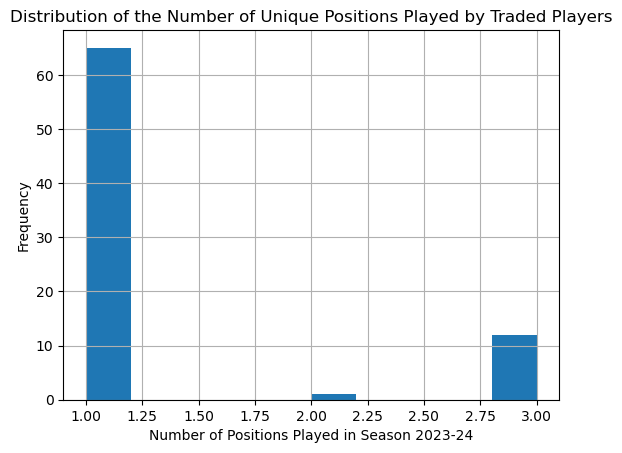

In [1506]:
df.loc[df['Player Name'].isin(df['Player Name'].value_counts()[df['Player Name'].value_counts() > 1].index)].groupby('Player Name')['Position'].nunique().hist()
plt.title('Distribution of the Number of Unique Positions Played by Traded Players')
plt.ylabel('Frequency')
plt.xlabel('Number of Positions Played in Season 2023-24')

Of the players traded in the 2023-2024 season, most retained their position on the basketball court.

Archetype
2    40.257353
0    35.294118
1    14.889706
5     5.698529
4     2.941176
3     0.919118
Name: proportion, dtype: float64


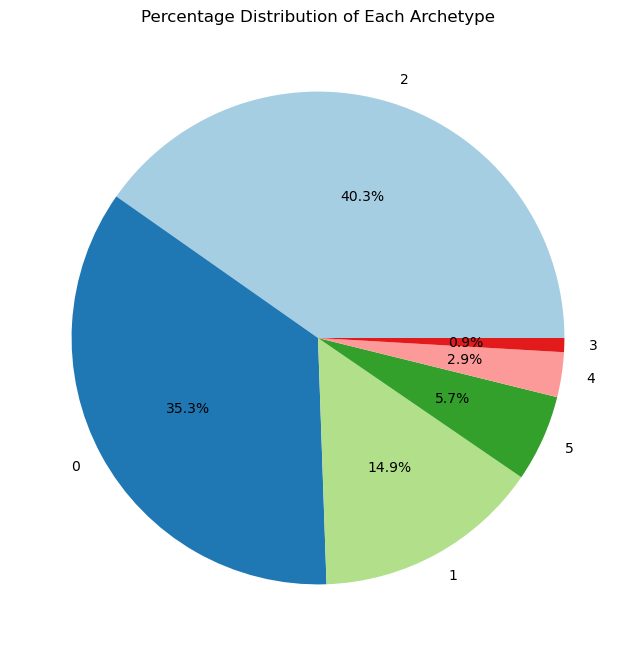

In [1508]:
# Calculate the percentage of each archetype
archetype_counts = aggregated_df['Archetype'].value_counts(normalize=True) * 100

# Display the results as percentages
print(archetype_counts)

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(archetype_counts, labels=archetype_counts.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Percentage Distribution of Each Archetype')
plt.show()

In [1510]:
aggregated_df.groupby('Archetype')['Player Name'].count()

Archetype
0    192
1     81
2    219
3      5
4     16
5     31
Name: Player Name, dtype: int64

In [1511]:
scaled_df['Archetype']=labels
scaled_df.head(10)
df = scaled_df.copy()

In [1513]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Minutes Per Game                   544 non-null    float64
 1   Field Goals Made                   544 non-null    float64
 2   Field Goals Attempted              544 non-null    float64
 3   Three-Point Field Goals Made       544 non-null    float64
 4   Three-Point Field Goals Attempted  544 non-null    float64
 5   Two-Point Field Goals Made         544 non-null    float64
 6   Two-Point Field Goals Attempted    544 non-null    float64
 7   Free Throws Made                   544 non-null    float64
 8   Free Throws Attempted              544 non-null    float64
 9   Offensive Rebounds                 544 non-null    float64
 10  Defensive Rebounds                 544 non-null    float64
 11  Assists                            544 non-null    float64

In [1515]:
df_original.head() 

,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Per Game,Field Goals Made,Field Goals Attempted,...,Free Throw Percentage,Offensive Rebounds,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points
0,1,Precious Achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,...,0.616,2.6,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6
1,1,Precious Achiuwa,C,24,TOR,25,0,17.5,3.1,6.8,...,0.571,2.0,3.4,5.4,1.8,0.6,0.5,1.2,1.6,7.7
2,1,Precious Achiuwa,PF,24,NYK,49,18,24.2,3.2,6.1,...,0.643,2.9,4.3,7.2,1.1,0.6,1.1,1.1,2.1,7.6
4,3,Ochai Agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,...,0.661,0.9,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8
5,3,Ochai Agbaji,SG,23,UTA,51,10,19.7,2.1,4.9,...,0.750,0.7,1.8,2.5,0.9,0.5,0.6,0.7,1.3,5.4


,Rank,Player Name,Position,Age,Team,Games Played,Games Started,Minutes Per Game,Field Goals Made,Field Goals Attempted,...,Defensive Rebounds,Total Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Archetype,Salary 2023/24
0,1,Precious Achiuwa,PF-C,24,TOT,74,18,21.9,3.2,6.3,...,4.0,6.6,1.3,0.6,0.9,1.1,1.9,7.6,5,4379526
1,1,Precious Achiuwa,C,24,TOR,25,0,17.5,3.1,6.8,...,3.4,5.4,1.8,0.6,0.5,1.2,1.6,7.7,5,4379526
2,1,Precious Achiuwa,PF,24,NYK,49,18,24.2,3.2,6.1,...,4.3,7.2,1.1,0.6,1.1,1.1,2.1,7.6,5,4379526
3,3,Ochai Agbaji,SG,23,TOT,78,28,21.0,2.3,5.6,...,1.8,2.8,1.1,0.6,0.6,0.8,1.5,5.8,5,4114200
4,3,Ochai Agbaji,SG,23,UTA,51,10,19.7,2.1,4.9,...,1.8,2.5,0.9,0.5,0.6,0.7,1.3,5.4,5,4114200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,568,Thaddeus Young,PF,35,TOT,33,6,13.3,2.0,3.3,...,1.7,3.1,1.7,0.7,0.2,0.5,1.5,4.2,5,9010371
595,568,Thaddeus Young,PF,35,TOR,23,6,15.2,2.3,3.8,...,2.0,3.3,2.2,0.8,0.1,0.5,1.7,5.0,5,9010371
596,568,Thaddeus Young,PF,35,PHO,10,0,8.9,1.1,2.1,...,1.1,2.8,0.7,0.5,0.2,0.4,1.1,2.3,5,9010371
597,570,Omer Yurtseven,C,25,UTA,48,12,11.4,2.1,3.8,...,2.8,4.3,0.6,0.2,0.4,0.8,1.1,4.6,2,2800000


Archetype
0    195
1    108
2    189
3     12
4     39
5     56
Name: Position, dtype: int64


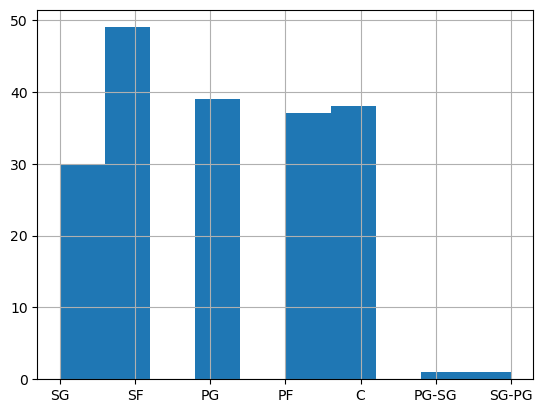

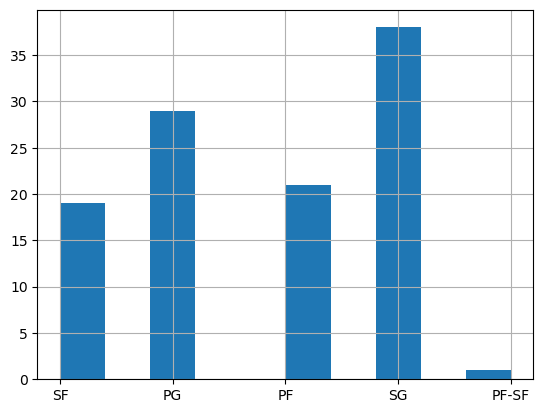

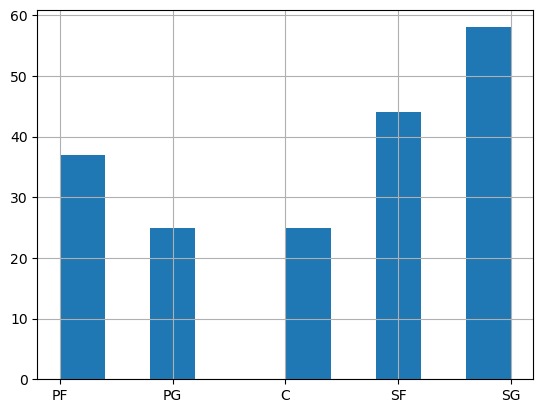

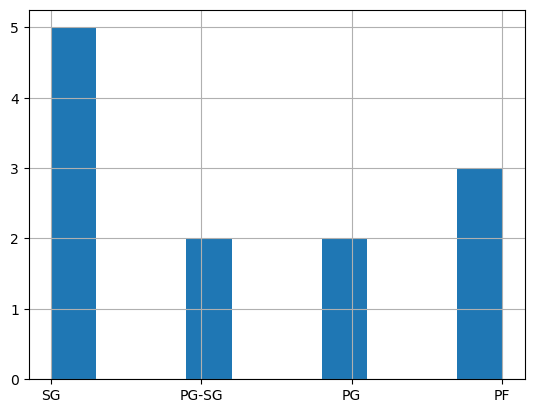

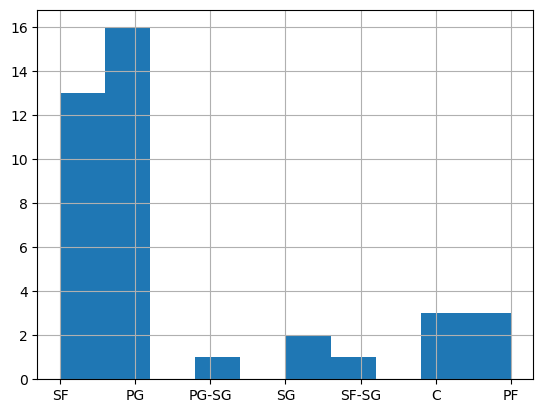

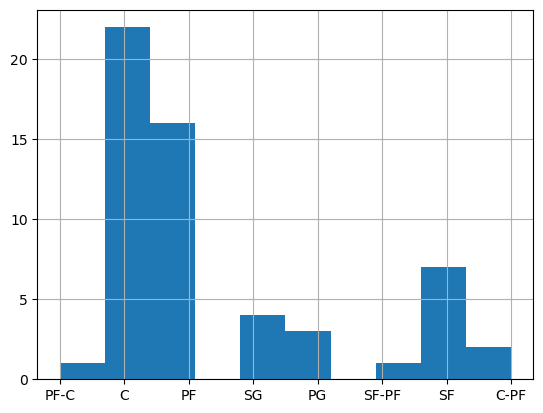

In [1516]:
df_original = pd.merge(df_original, aggregated_df[['Player Name', 'Archetype']], on='Player Name', how='inner')
df_original = pd.merge(df_original, df_salaries[['Player Name', 'Salary 2023/24']], on='Player Name', how='inner')
aggregated_df = pd.merge(aggregated_df, df_salaries[['Player Name', 'Salary 2023/24']], on='Player Name', how='inner')


# Display the updated DataFrame
display(df_original)
print(df_original.groupby('Archetype')['Position'].count())
for i in range(df_original['Archetype'].nunique()):
    subset=df_original[df_original['Archetype']==i]
    subset['Position'].hist()
    plt.show()

Histograms demonstrate that their is no one-to-one relation between the basketball archetypes and the traditional basketball team-member roles on the court. It suggests an ability to play an archetypal role independently of a team position. 

In [1520]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Rank                               599 non-null    int64  
 1   Player Name                        599 non-null    object 
 2   Position                           599 non-null    object 
 3   Age                                599 non-null    int64  
 4   Team                               599 non-null    object 
 5   Games Played                       599 non-null    int64  
 6   Games Started                      599 non-null    int64  
 7   Minutes Per Game                   599 non-null    float64
 8   Field Goals Made                   599 non-null    float64
 9   Field Goals Attempted              599 non-null    float64
 10  Field Goal Percentage              599 non-null    float64
 11  Three-Point Field Goals Made       599 non-null    float64

## Data Splitting

In [1582]:
# Extract the feature variables
features = df.drop(columns=['Archetype'], axis=1)

df['Archetype'] = df['Archetype'].astype(float)
target = df['Archetype']

# Split data: 60% for training, 20% for validation, and 20% for testing
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size=0.4, random_state=12345)

# Further split the remaining 40% into validation (20%) and test (20%) sets
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, random_state=12345)

# Print the size of each dataset
print('Training Features Size:', features_train.shape)
print()
print('Validation Features Size:', features_valid.shape)
print()
print('Test Features Size:', features_test.shape)

Training Features Size: (326, 17)

Validation Features Size: (109, 17)

Test Features Size: (109, 17)


In [1583]:
# Model evaluation function
def model_eval(model, features_train, features_valid, target_train, target_valid):
    
    # Train the model on the training data
    model.fit(features_train, target_train)

    # Generate predictions on the validation set
    predictions = model.predict(features_valid)
    probabilities_test = model.predict_proba(features_valid)
   # probabilities_one_valid = probabilities_test[:, 1]

    # Calculate the AUC-ROC, Accuracy and F1 scores of the predictions
    accuracy = accuracy_score(target_valid, predictions)
    f1 = f1_score(target_valid, predictions, average='weighted')

    # Print out the AUC-ROC, Accuracy and F1 scores
    print("Accuracy:", accuracy)
    print("F1:", f1)
    print(classification_report(target_valid, predictions, zero_division=np.nan))

    return accuracy, f1

In [1584]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Minutes Per Game                   544 non-null    float64
 1   Field Goals Made                   544 non-null    float64
 2   Field Goals Attempted              544 non-null    float64
 3   Three-Point Field Goals Made       544 non-null    float64
 4   Three-Point Field Goals Attempted  544 non-null    float64
 5   Two-Point Field Goals Made         544 non-null    float64
 6   Two-Point Field Goals Attempted    544 non-null    float64
 7   Free Throws Made                   544 non-null    float64
 8   Free Throws Attempted              544 non-null    float64
 9   Offensive Rebounds                 544 non-null    float64
 10  Defensive Rebounds                 544 non-null    float64
 11  Assists                            544 non-null    float64

6
Distribution of metrics for the 0 archetype.


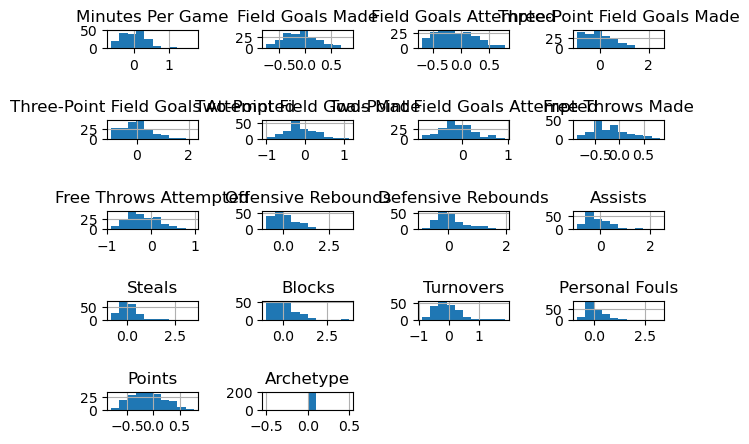

Distribution of metrics for the 1 archetype.


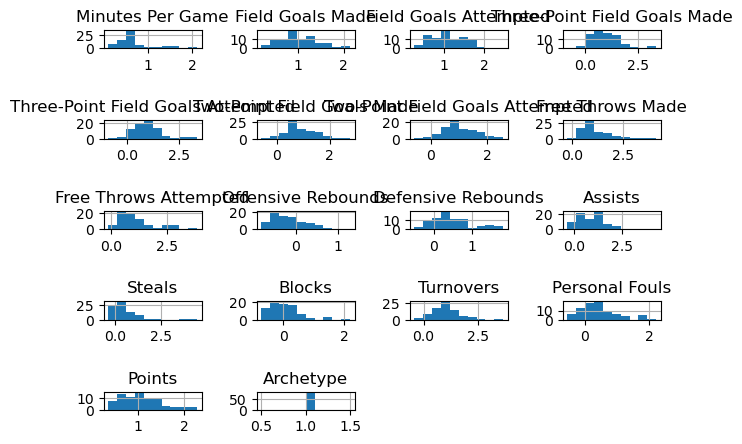

Distribution of metrics for the 2 archetype.


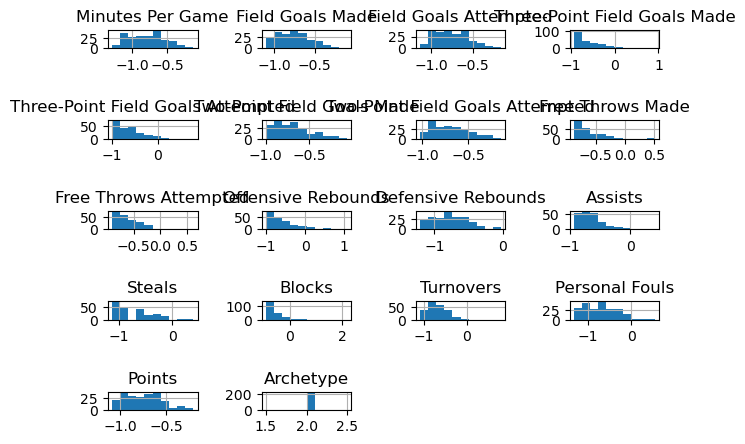

Distribution of metrics for the 3 archetype.


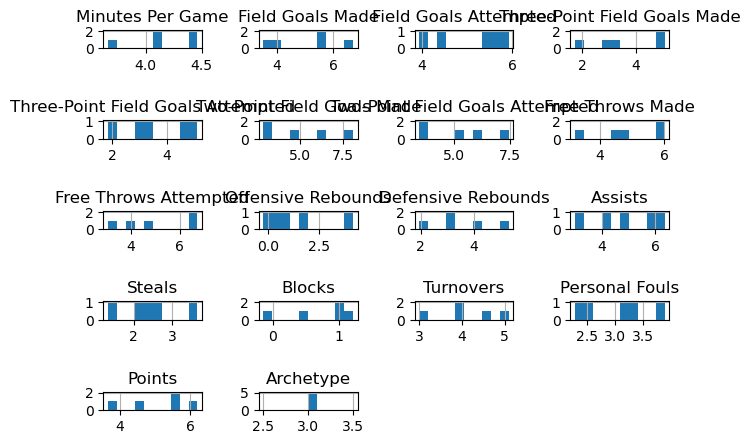

Distribution of metrics for the 4 archetype.


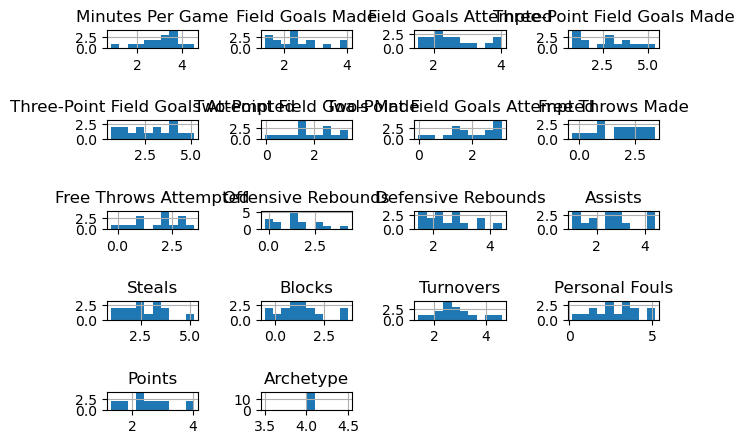

Distribution of metrics for the 5 archetype.


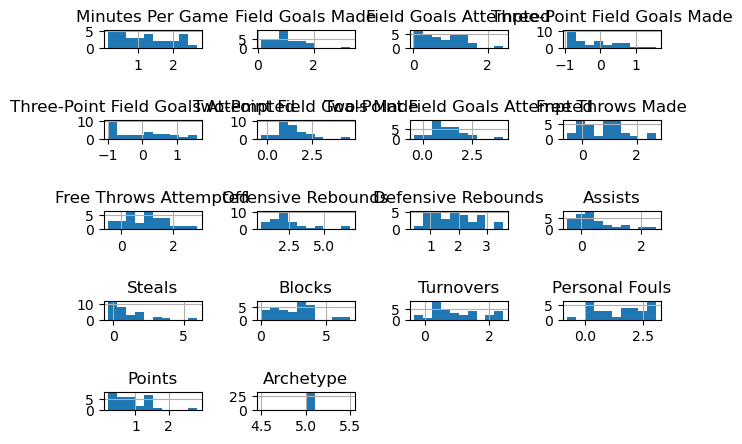

CPU times: user 7.1 s, sys: 343 ms, total: 7.44 s
Wall time: 4.71 s


In [1587]:
%%time
print(df['Archetype'].nunique())
for i in range(0, df['Archetype'].nunique()):
    # Filter the DataFrame for the current genre
    subset = df[df['Archetype'] == i]

    print(f'Distribution of metrics for the {i} archetype.')
    #plt.figure(figsize=(10, 10))  # Optional: adjust figure size
    subset.hist(bins=10)
    plt.tight_layout(pad=2)
    plt.show()

In [1588]:
print(aggregated_df['Archetype'].nunique())
for i in range(0, aggregated_df['Archetype'].nunique()):
    # Filter the DataFrame for the current genre
    subset = aggregated_df[aggregated_df['Archetype'] == i]
    display(subset.describe())

6


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
count,165.0,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,165.000000,1.650000e+02
mean,0.0,23.250303,3.295758,7.085455,1.107879,3.077576,2.178182,4.003030,1.007273,1.354545,1.140606,3.056364,2.164848,0.800000,0.522424,1.043030,1.947879,8.706667,7.097993e+06
std,0.0,6.246117,1.046618,2.269287,0.783674,1.937038,0.936592,1.626624,0.538467,0.687648,0.731845,1.167199,1.437766,0.397707,0.376821,0.427874,0.616500,2.821242,7.170007e+06
min,0.0,11.900000,1.200000,3.100000,0.000000,0.000000,0.300000,0.600000,0.000000,0.000000,0.100000,0.700000,0.000000,0.200000,0.000000,0.200000,0.700000,2.600000,6.434300e+04
25%,0.0,18.500000,2.500000,5.300000,0.600000,1.900000,1.600000,3.000000,0.600000,0.900000,0.600000,2.300000,1.200000,0.500000,0.300000,0.700000,1.500000,6.700000,2.306400e+06
50%,0.0,22.900000,3.200000,6.900000,1.100000,3.100000,2.000000,3.800000,1.000000,1.300000,0.900000,2.900000,1.700000,0.700000,0.500000,1.000000,1.800000,8.500000,4.640000e+06
75%,0.0,27.100000,4.000000,8.700000,1.500000,4.000000,2.800000,5.100000,1.300000,1.800000,1.500000,3.700000,2.800000,0.900000,0.700000,1.300000,2.200000,10.800000,9.835881e+06
max,0.0,46.000000,5.800000,12.900000,4.200000,10.500000,5.300000,8.800000,2.700000,3.700000,4.600000,6.800000,8.300000,3.000000,2.400000,2.600000,4.200000,15.700000,3.789341e+07


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
count,75.0,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.00000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,7.500000e+01
mean,1.0,35.454667,7.048000,15.608000,2.281333,6.316000,4.762667,9.297333,3.31600,4.000000,0.885333,4.202667,4.696000,1.093333,0.497333,2.177333,2.386667,19.681333,1.964822e+07
std,0.0,7.104610,1.435963,2.967516,0.897849,2.487267,1.493931,2.520670,1.42687,1.663032,0.430491,1.339824,1.550365,0.517879,0.253608,0.595382,0.823856,4.087677,1.423769e+07
min,1.0,26.000000,4.300000,10.700000,0.100000,0.300000,2.300000,4.600000,1.00000,1.500000,0.200000,1.700000,1.500000,0.500000,0.100000,0.700000,1.100000,13.000000,3.981600e+05
25%,1.0,31.500000,5.950000,13.250000,1.700000,4.850000,3.700000,7.600000,2.40000,3.000000,0.500000,3.400000,3.600000,0.800000,0.300000,1.700000,1.850000,16.150000,7.265280e+06
50%,1.0,33.500000,6.800000,15.500000,2.200000,6.100000,4.400000,8.900000,2.90000,3.600000,0.800000,3.800000,4.900000,1.000000,0.500000,2.100000,2.300000,19.400000,1.730769e+07
75%,1.0,36.650000,8.000000,17.750000,2.800000,7.300000,5.600000,10.800000,3.90000,4.550000,1.100000,4.800000,5.450000,1.200000,0.600000,2.500000,2.700000,22.600000,3.299346e+07
max,1.0,59.500000,10.600000,25.100000,5.300000,14.300000,9.300000,16.200000,7.90000,9.300000,2.300000,7.400000,8.500000,3.600000,1.300000,3.800000,4.900000,30.100000,5.191562e+07


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
count,187.0,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,1.870000e+02
mean,2.0,9.311765,1.154545,2.713904,0.397326,1.254011,0.758289,1.461497,0.396257,0.552941,0.481818,1.101604,0.768984,0.280214,0.186096,0.377005,0.852941,3.097861,2.250642e+06
std,0.0,4.553714,0.683302,1.407208,0.402203,1.018497,0.540682,0.863111,0.379639,0.492993,0.425265,0.664578,0.564640,0.222846,0.209247,0.234534,0.522843,1.806766,2.655553e+06
min,2.0,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.538900e+04
25%,2.0,5.200000,0.600000,1.600000,0.100000,0.400000,0.300000,0.800000,0.100000,0.200000,0.200000,0.600000,0.400000,0.100000,0.100000,0.200000,0.450000,1.650000,5.597820e+05
50%,2.0,9.200000,1.100000,2.600000,0.300000,1.100000,0.700000,1.400000,0.300000,0.500000,0.400000,1.100000,0.600000,0.200000,0.100000,0.400000,0.900000,3.000000,1.708143e+06
75%,2.0,12.300000,1.600000,3.550000,0.600000,1.900000,1.050000,2.100000,0.550000,0.800000,0.700000,1.500000,1.050000,0.400000,0.300000,0.500000,1.200000,4.300000,3.124625e+06
max,2.0,20.900000,3.300000,6.800000,2.300000,5.800000,2.300000,4.000000,2.200000,3.000000,2.100000,2.900000,3.000000,1.000000,1.600000,1.100000,2.600000,8.000000,1.992857e+07


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
count,4.0,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000e+00
mean,3.0,95.325000,21.625000,45.350000,5.700000,15.350000,16.000000,29.975000,9.825000,12.575000,2.625000,12.52500,13.425000,2.300000,0.875000,5.325000,6.000000,58.850000,2.228853e+07
std,0.0,6.407483,3.505591,4.497777,2.001666,5.060632,5.436298,7.606302,1.273774,2.772935,1.883923,2.62091,2.910183,0.627163,0.320156,0.903235,1.029563,6.069322,1.384585e+07
min,3.0,86.500000,17.000000,39.000000,3.300000,9.300000,9.500000,20.200000,8.400000,9.700000,0.800000,10.40000,9.800000,1.600000,0.400000,4.300000,5.000000,50.600000,4.171548e+06
25%,3.0,92.650000,20.525000,43.875000,4.425000,12.150000,13.175000,26.725000,8.925000,10.450000,1.550000,10.47500,12.125000,1.975000,0.850000,4.975000,5.225000,57.200000,1.844680e+07
50%,3.0,97.200000,22.000000,46.600000,6.050000,16.000000,16.050000,30.650000,10.000000,12.800000,2.250000,11.90000,13.550000,2.250000,1.000000,5.250000,5.900000,59.800000,2.354458e+07
75%,3.0,99.875000,23.100000,48.075000,7.325000,19.200000,18.875000,33.900000,10.900000,14.925000,3.325000,13.95000,14.850000,2.575000,1.025000,5.600000,6.675000,61.450000,2.738630e+07
max,3.0,100.400000,25.500000,49.200000,7.400000,20.100000,22.400000,38.400000,10.900000,15.000000,5.200000,15.90000,16.800000,3.100000,1.100000,6.500000,7.200000,65.200000,3.789341e+07


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
count,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,1.300000e+01
mean,4.0,76.392308,10.984615,24.592308,4.361538,11.807692,6.676923,12.800000,3.876923,4.907692,2.630769,9.107692,9.153846,2.576923,1.153846,3.976923,5.915385,30.246154,1.445712e+07
std,0.0,12.118750,2.449778,4.445871,1.879512,4.563526,2.538423,4.514791,1.670406,2.106127,1.169319,1.673550,2.696175,0.644404,0.484106,0.853575,1.937716,6.080654,1.047586e+07
min,4.0,55.700000,8.100000,18.700000,2.200000,5.300000,2.300000,4.600000,0.900000,1.200000,1.000000,6.600000,4.800000,1.700000,0.200000,2.600000,3.000000,21.500000,2.019706e+06
25%,4.0,69.400000,9.400000,20.700000,2.400000,8.100000,5.500000,10.300000,2.800000,3.500000,2.200000,7.900000,7.200000,2.200000,1.000000,3.500000,4.300000,25.000000,3.191400e+06
50%,4.0,77.200000,11.100000,23.900000,4.800000,12.500000,6.400000,12.200000,4.000000,5.400000,2.300000,8.900000,8.600000,2.400000,1.100000,3.900000,6.100000,29.900000,1.240500e+07
75%,4.0,83.600000,12.400000,26.400000,6.000000,15.800000,8.800000,16.000000,5.200000,6.400000,2.800000,10.000000,10.700000,2.900000,1.400000,4.300000,7.200000,32.500000,2.041180e+07
max,4.0,102.200000,16.800000,34.500000,7.800000,20.300000,10.900000,18.700000,6.400000,7.900000,5.300000,12.200000,13.400000,4.100000,2.200000,6.000000,9.000000,43.900000,3.331940e+07


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
count,25.0,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.000000,25.0000,25.000000,25.000000,2.500000e+01
mean,5.0,44.560000,6.692000,13.000000,0.968000,3.136000,5.704000,9.856000,2.524000,3.484000,3.400000,7.376000,3.320000,1.484000,1.780000,2.1400,3.984000,16.864000,1.166368e+07
std,0.0,12.955855,1.640356,3.448188,0.966833,2.879942,1.949461,3.374547,1.172348,1.455072,1.363818,1.904005,1.741647,0.901702,0.844591,0.7932,1.590252,4.114495,1.174532e+07
min,5.0,25.800000,4.000000,8.100000,0.000000,0.000000,1.700000,2.700000,0.500000,0.800000,1.500000,4.000000,1.200000,0.500000,0.500000,0.8000,0.800000,11.400000,2.959770e+05
25%,5.0,34.100000,5.300000,10.600000,0.000000,0.200000,4.700000,8.000000,1.700000,2.400000,2.400000,5.900000,2.200000,0.900000,1.100000,1.6000,2.300000,13.500000,3.196448e+06
50%,5.0,42.900000,6.400000,12.300000,0.700000,3.400000,5.400000,10.100000,2.800000,3.600000,3.000000,7.200000,3.200000,1.200000,1.800000,2.0000,4.300000,16.500000,9.010371e+06
75%,5.0,55.900000,7.800000,15.700000,1.800000,5.500000,6.700000,11.300000,3.300000,4.300000,4.000000,8.700000,3.900000,1.800000,2.300000,2.6000,5.300000,21.100000,1.240200e+07
max,5.0,69.400000,9.700000,19.200000,3.100000,8.500000,9.700000,15.500000,5.500000,6.800000,7.500000,11.700000,8.600000,4.600000,4.000000,3.7000,6.100000,24.700000,4.100000e+07


In [1590]:
for i in range(0, aggregated_df['Archetype'].nunique()):
    subset = aggregated_df[aggregated_df['Archetype'] == i]
    median_row_df = pd.DataFrame(subset.describe().loc['50%', :]).T
    display(median_row_df)

,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
50%,0.0,22.9,3.2,6.9,1.1,3.1,2.0,3.8,1.0,1.3,0.9,2.9,1.7,0.7,0.5,1.0,1.8,8.5,4640000.0


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
50%,1.0,33.5,6.8,15.5,2.2,6.1,4.4,8.9,2.9,3.6,0.8,3.8,4.9,1.0,0.5,2.1,2.3,19.4,17307693.0


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
50%,2.0,9.2,1.1,2.6,0.3,1.1,0.7,1.4,0.3,0.5,0.4,1.1,0.6,0.2,0.1,0.4,0.9,3.0,1708143.0


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
50%,3.0,97.2,22.0,46.6,6.05,16.0,16.05,30.65,10.0,12.8,2.25,11.9,13.55,2.25,1.0,5.25,5.9,59.8,23544575.0


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
50%,4.0,77.2,11.1,23.9,4.8,12.5,6.4,12.2,4.0,5.4,2.3,8.9,8.6,2.4,1.1,3.9,6.1,29.9,12405000.0


,Archetype,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Salary 2023/24
50%,5.0,42.9,6.4,12.3,0.7,3.4,5.4,10.1,2.8,3.6,3.0,7.2,3.2,1.2,1.8,2.0,4.3,16.5,9010371.0


The above statistics represent the performance of the typical player by archetype and we focus specifically on the performance of the median player. With some of this data we can define traits of the various archetypes, but some of the data is more muddled and mixed and thus prevents obvious definition:

0: Second Lowest Point Getter

1: Two turnovers per player

2: Lowest Point Getters: Data suggests these player may play a support or defensive role.

3: Point-Getter: This player spends the most time on the court and scores the most points. Makes most defensive rebounds.

4: Second highest number of assists

5: Rebounder: Makes most offensive rebounds.

In [1592]:
for i in range(0, df['Archetype'].nunique()):
    subset = df[df['Archetype'] == i][:]  
    display(subset.describe())

,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Archetype
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.0
mean,0.044943,-0.076085,-0.085303,0.006987,-0.008759,-0.106714,-0.125430,-0.202057,-0.190938,0.123732,0.074412,-0.075621,0.119035,0.077068,-0.080886,0.094897,-0.090507,0.0
std,0.387988,0.327119,0.344753,0.643264,0.614750,0.382179,0.361134,0.355994,0.361137,0.708062,0.509398,0.564881,0.616789,0.714950,0.418584,0.499966,0.326614,0.0
min,-0.638435,-0.739691,-0.690547,-0.930616,-0.997764,-0.999117,-0.891385,-0.871813,-0.908692,-0.908527,-0.926571,-0.942478,-0.831210,-0.914128,-0.904931,-0.824704,-0.802414,0.0
25%,-0.247848,-0.319163,-0.360128,-0.445388,-0.418648,-0.350864,-0.360870,-0.492855,-0.450179,-0.410302,-0.270357,-0.461100,-0.367754,-0.526532,-0.428375,-0.246281,-0.332009,0.0
50%,0.015907,-0.066846,-0.115905,-0.041030,-0.052891,-0.188801,-0.161926,-0.240216,-0.195449,-0.011723,-0.024276,-0.260525,0.095701,-0.042037,-0.142441,-0.029373,-0.108007,0.0
75%,0.266690,0.147241,0.171415,0.383545,0.350965,0.135326,0.125437,0.012423,0.059281,0.486501,0.303831,0.180738,0.288808,0.442458,0.143492,0.277914,0.138396,0.0
max,1.713738,0.850670,0.774789,2.465985,2.202611,1.148221,0.921211,0.833499,0.976308,3.575492,1.944367,2.387055,3.494376,3.737023,1.859095,3.224252,0.776802,0.0


,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Archetype
count,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.000000,81.0
mean,0.724200,1.032663,1.094744,0.925434,0.943157,0.903625,1.001716,1.199202,1.107761,-0.122439,0.482062,0.935491,0.582044,0.078788,0.989527,0.433008,1.095660,1.0
std,0.432466,0.437384,0.427930,0.749088,0.772315,0.620251,0.582414,0.891185,0.841644,0.422170,0.543105,0.740663,0.784350,0.538101,0.648604,0.595750,0.454720,0.0
min,0.122562,0.208409,0.257612,-0.849745,-0.906325,-0.593959,-0.581918,-0.240216,-0.144503,-0.808882,-0.516437,-0.340755,-0.367754,-0.720330,-0.428375,-0.535492,0.351198,1.0
25%,0.485765,0.667167,0.760423,0.444198,0.465265,0.499968,0.655953,0.644020,0.517794,-0.509947,0.180791,0.461542,0.095701,-0.332734,0.524737,0.042930,0.709601,1.0
50%,0.606833,0.973005,1.062110,0.848556,0.861502,0.783579,0.921211,0.959819,0.874416,-0.211013,0.344844,0.983035,0.404672,0.054862,0.905982,0.332141,1.045605,1.0
75%,0.797082,1.340012,1.392529,1.333784,1.257738,1.269768,1.363307,1.528256,1.332929,0.087922,0.713965,1.223724,0.868127,0.248660,1.287227,0.765958,1.426409,1.0
max,2.105767,2.135192,2.469983,3.355571,3.360842,2.768853,2.556968,4.117804,3.829280,1.283660,1.821327,4.312567,4.421288,2.186639,3.670008,2.212013,2.277618,1.0


,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Archetype
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.0
mean,-0.793646,-0.754913,-0.748405,-0.614147,-0.624213,-0.691086,-0.698700,-0.619174,-0.623023,-0.545437,-0.769634,-0.635663,-0.720460,-0.559274,-0.727365,-0.724668,-0.747846,2.0
std,0.259218,0.209414,0.203325,0.323177,0.308672,0.218640,0.196805,0.242815,0.259642,0.407966,0.272752,0.236636,0.334891,0.410216,0.254791,0.374731,0.203045,0.0
min,-1.295660,-1.106697,-1.135895,-0.930616,-0.997764,-0.999117,-1.024014,-0.871813,-0.908692,-1.008171,-1.213665,-0.942478,-1.140180,-0.914128,-1.095554,-1.330823,-1.093617,2.0
25%,-1.027582,-0.923194,-0.898855,-0.890181,-0.875845,-0.877569,-0.847176,-0.808653,-0.832273,-0.808882,-0.967585,-0.782018,-0.985695,-0.914128,-0.904931,-1.005461,-0.914415,2.0
50%,-0.794094,-0.770275,-0.762378,-0.688002,-0.692966,-0.715506,-0.714547,-0.682334,-0.653962,-0.609592,-0.803531,-0.701789,-0.831210,-0.720330,-0.714309,-0.680098,-0.757614,2.0
75%,-0.618257,-0.617356,-0.618717,-0.445388,-0.449128,-0.553443,-0.559813,-0.492855,-0.501124,-0.360480,-0.598464,-0.541329,-0.522240,-0.332734,-0.618997,-0.463190,-0.612012,2.0
max,-0.119573,-0.097430,-0.159004,0.929427,0.770062,-0.067253,-0.139821,0.517701,0.619686,1.084370,-0.024276,0.421427,0.404672,2.186639,0.810671,0.549049,-0.197608,2.0


,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Archetype
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,4.152389,5.114061,5.090350,3.614360,3.598584,4.989119,5.213969,4.913616,5.011226,1.383305,3.527484,4.826037,2.412980,0.713775,4.089378,3.036265,5.126927,3.0
std,0.322641,1.278428,0.854424,1.409346,1.348432,2.204559,1.694909,1.169393,1.637181,1.701274,1.284447,1.325126,0.839070,0.558326,0.784800,0.647907,1.016734,0.0
min,3.662352,3.542050,3.935319,1.738142,1.836854,2.849885,3.441162,3.233568,3.065091,-0.211013,1.944367,2.988777,1.331583,-0.138936,3.002830,2.284316,3.644032,3.0
25%,4.077442,4.092560,4.466863,2.951214,2.995085,3.011948,3.662210,4.433602,4.033064,0.486501,3.051729,4.232338,2.104009,0.442458,3.860631,2.501224,4.573642,3.0
50%,4.135093,5.530002,5.400656,3.355571,3.269403,4.835159,5.364282,4.875720,4.542523,0.785436,3.092742,4.753831,2.412980,1.023852,3.955942,3.151949,5.559252,3.0
75%,4.423350,5.713505,5.716709,4.973000,4.762911,6.172180,6.137951,6.012595,6.682253,1.682240,4.241118,5.796817,2.567465,1.023852,4.527809,3.368858,5.648853,3.0
max,4.463706,6.692188,5.932200,5.053872,5.128668,8.076423,7.464241,6.012595,6.733199,4.173361,5.307466,6.358424,3.648862,1.217649,5.099677,3.874977,6.208858,3.0


,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Archetype
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.0
mean,3.000804,2.429562,2.566056,2.769253,2.789346,1.849651,1.929744,1.788790,1.839205,1.464266,2.564695,2.555036,2.673674,1.278211,2.770508,2.772360,2.484120,4.0
std,0.878755,0.816299,0.756801,1.473104,1.378795,0.981979,0.956261,1.101680,1.129801,1.212351,0.819567,1.104358,1.100673,1.194061,0.804966,1.449786,0.773873,0.0
min,0.837438,1.370596,1.550556,0.848556,0.617663,-0.067253,-0.007192,-0.303376,-0.297341,-0.211013,1.493220,0.983035,1.022613,-0.526532,1.382539,0.187535,1.314408,4.0
25%,2.603010,1.791124,2.042593,1.434874,1.539676,1.320413,1.418569,0.896659,0.912625,0.611057,1.975127,1.735188,1.872281,0.636256,2.383307,1.705894,2.067616,4.0
50%,3.149256,2.333988,2.347871,2.991649,2.918885,1.816732,1.949085,1.812475,2.097118,1.283660,2.354501,2.487342,2.567465,1.120751,2.669240,2.862738,2.428819,4.0
75%,3.509576,2.815683,2.908147,3.941889,3.863758,2.616919,2.656440,2.538811,2.721206,1.956263,2.918435,3.079036,3.378512,1.847493,3.026657,3.658069,2.846024,4.0
max,4.567478,4.031392,4.021516,5.377358,5.189628,3.417106,3.109589,3.423047,3.523605,4.273006,4.405171,4.432912,5.193714,3.737023,4.623121,5.176427,4.036036,4.0


,Minutes Per Game,Field Goals Made,Field Goals Attempted,Three-Point Field Goals Made,Three-Point Field Goals Attempted,Two-Point Field Goals Made,Two-Point Field Goals Attempted,Free Throws Made,Free Throws Attempted,Offensive Rebounds,Defensive Rebounds,Assists,Steals,Blocks,Turnovers,Personal Fouls,Points,Archetype
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.0
mean,1.217565,1.027267,0.809546,-0.134946,-0.020445,1.422683,1.258488,0.776452,0.931935,2.427969,1.823973,0.417545,1.062480,2.492965,0.964399,1.479656,0.871823,5.0
std,0.743431,0.630933,0.570361,0.735915,0.834498,0.933431,0.865727,0.833510,0.813301,1.507213,0.769183,0.703735,1.346161,1.553428,0.792738,1.082892,0.576277,0.0
min,0.162918,0.116657,0.027755,-0.930616,-0.997764,-0.310348,-0.427184,-0.556014,-0.501124,0.486501,0.426871,-0.461100,-0.367754,0.054862,-0.333064,-0.752401,0.183196,5.0
25%,0.595303,0.529539,0.408455,-0.930616,-0.921565,0.945642,0.755425,0.107163,0.339484,1.482950,1.226632,-0.080008,0.018459,1.120751,0.429426,0.476746,0.446399,5.0
50%,1.148755,0.881254,0.760423,-0.283645,0.038548,1.188737,1.252783,0.896659,0.925362,1.981174,1.739300,0.341197,0.713642,2.574235,0.715360,1.633591,0.776802,5.0
75%,1.794450,1.355304,1.184222,0.484634,0.617663,1.755958,1.628565,1.212457,1.358402,2.927800,2.292981,0.662116,1.640554,3.349427,1.477850,2.465073,1.286407,5.0
max,2.676515,3.297379,2.412519,1.576399,1.593016,4.632580,4.104307,2.728290,2.912253,6.863772,3.584903,2.507399,5.966140,6.837789,2.430962,3.079647,2.848824,5.0


## RandomForestClassifier

In [1594]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=12345)

# Set up RandomizedSearchCV for tuning the Random Forest model
rf_random_search = RandomizedSearchCV(
    rf_model, 
    param_distributions={'n_estimators': [10, 50, 100, 200], 
                         'max_features': ['sqrt', 'log2'],
                         'max_depth': [None, 10, 20, 30, 40],
                         'min_samples_split': [2, 5, 10], 
                         'min_samples_leaf': [1, 2, 4]}, 
    n_iter=10,     
    cv=5,                        
    scoring='accuracy',
    n_jobs=-1,                      
    random_state=12345
)

# Fit the RandomizedSearchCV object to the training data
rf_random_search.fit(features_train, target_train)

print("BEST RANDOM FOREST HYPERPARAMETERS:", rf_random_search.best_params_)
print()

# Get the best Random Forest model from the search
tuned_rf_model = rf_random_search.best_estimator_

print("RANDOM FOREST STATS:")
print("--------------------")

# Evaluate the tuned Random Forest model
rf_accuracy, rf_f1 = model_eval(tuned_rf_model, features_train, features_valid, target_train, target_valid)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



BEST RANDOM FOREST HYPERPARAMETERS: {'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 20}

RANDOM FOREST STATS:
--------------------
Accuracy: 0.8990825688073395
F1: 0.8984900592293107
              precision    recall  f1-score   support

         0.0       0.81      0.97      0.88        35
         1.0       0.92      0.75      0.83        16
         2.0       1.00      0.94      0.97        48
         3.0       1.00      1.00      1.00         1
         4.0       1.00      0.50      0.67         2
         5.0       0.71      0.71      0.71         7

    accuracy                           0.90       109
   macro avg       0.91      0.81      0.84       109
weighted avg       0.91      0.90      0.90       109



In [1595]:
# Split the data into features (X) and target (y)
X = df.drop(columns=['Archetype'])
y = df['Archetype']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

# Feature importance (to see which features were most important for classification)
feature_importance = pd.DataFrame(rf_model.feature_importances_, index=X.columns, columns=['Importance'])
print(feature_importance.sort_values(by='Importance', ascending=False))


Accuracy: 0.9174311926605505
              precision    recall  f1-score   support

         0.0       0.87      0.97      0.92        34
         1.0       0.89      0.94      0.92        18
         2.0       1.00      0.90      0.95        48
         3.0       1.00      1.00      1.00         1
         4.0       1.00      0.67      0.80         3
         5.0       0.67      0.80      0.73         5

    accuracy                           0.92       109
   macro avg       0.90      0.88      0.88       109
weighted avg       0.93      0.92      0.92       109

                                   Importance
Points                               0.177760
Field Goals Attempted                0.145012
Minutes Per Game                     0.112447
Field Goals Made                     0.092154
Defensive Rebounds                   0.061836
Two-Point Field Goals Attempted      0.057050
Offensive Rebounds                   0.054405
Personal Fouls                       0.046400
Turnovers     

In [1596]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Minutes Per Game                   544 non-null    float64
 1   Field Goals Made                   544 non-null    float64
 2   Field Goals Attempted              544 non-null    float64
 3   Three-Point Field Goals Made       544 non-null    float64
 4   Three-Point Field Goals Attempted  544 non-null    float64
 5   Two-Point Field Goals Made         544 non-null    float64
 6   Two-Point Field Goals Attempted    544 non-null    float64
 7   Free Throws Made                   544 non-null    float64
 8   Free Throws Attempted              544 non-null    float64
 9   Offensive Rebounds                 544 non-null    float64
 10  Defensive Rebounds                 544 non-null    float64
 11  Assists                            544 non-null    float64

## XGBClassifier

In [1598]:
# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=12345)

# Set up RandomizedSearchCV for tuning the XGBoost model
xgb_random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions={'n_estimators': [50, 100, 200, 300],
                         'max_depth': [3, 5, 7, 10],
                         'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'subsample': [0.6, 0.8, 1.0],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.5, 1],
                         'reg_alpha': [0, 0.1, 0.5, 1],
                         'reg_lambda': [0, 0.1, 0.5, 1]}, 
    n_iter=10,                      
    cv=3,                      
    scoring='accuracy', 
    n_jobs=-1,                     
    random_state=12345,
    error_score='raise'
)

# Fit the RandomizedSearchCV object to the training data
xgb_random_search.fit(features_train, target_train)

print("BEST XGBOOST HYPERPARAMETERS:", xgb_random_search.best_params_)
print()

# Get the best XGBoost model from the search
tuned_xgb_model = xgb_random_search.best_estimator_

print("XGBOOST STATS:")
print("--------------")

# Evaluate the tuned XGBoost model
xgb_accuracy, xgb_f1 = model_eval(tuned_xgb_model, features_train, features_valid, target_train, target_valid)
#df['Archetype'] = df['Archetype'].astype(str)

BEST XGBOOST HYPERPARAMETERS: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.6}

XGBOOST STATS:
--------------
Accuracy: 0.8807339449541285
F1: 0.877506310006007
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89        35
         1.0       0.87      0.81      0.84        16
         2.0       1.00      0.92      0.96        48
         3.0        nan      0.00      0.00         1
         4.0       0.00      0.00      0.00         2
         5.0       0.71      0.71      0.71         7

    accuracy                           0.88       109
   macro avg       0.68      0.57      0.57       109
weighted avg       0.89      0.88      0.88       109



## Predict function

In [1641]:
def predict_archetype(df: pd.DataFrame, model):

    try:
        df = df.drop(columns=['Age', 
                          'Rank', 
                          'Position', 
                          'Team',
                          'Games Played',
                          'Games Started',
                          'Field Goal Percentage',
                          'Three-Point Field Goal Percentage', 
                          'Two-Point Field Goal Percentage', 
                          'Effective Field Goal Percentage',
                          'Free Throw Percentage', 
                          'Total Rebounds'
                          ])
    except KeyError as e:
        print('Did not need to drop unnecessary fields.')
    
    # Prepare features for model prediction (remove unnecessary columns)
    try:
        features = df.drop(columns=['Archetype'], axis=1)
        # If a specific feature is missing, add a placeholder
        if features.shape[1] == 18:
            features['placeholder_feature'] = 0.0

    except KeyError as e:
        print(f"Error in feature extraction: {e}")
        return None
    
    # Ensure the features are in the correct shape for prediction
    print(f"Features shape before reshaping: {features.shape}")
    try:
        features = features.values.reshape(1, -1)  # Reshape to ensure it's compatible with the model input
    except ValueError as e:
        print(f"Error in reshaping features: {e}")
        return None
    
    try:
        predicted_archetype_num = model.predict(features)[0].astype(float)
        print(f"Predicted Archetype: {predicted_archetype_num}")
        return predicted_archetype_num
    except Exception as e:
        print(f"Error during model prediction: {e}")
        print(features)
        return None

In [1643]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Minutes Per Game                   544 non-null    float64
 1   Field Goals Made                   544 non-null    float64
 2   Field Goals Attempted              544 non-null    float64
 3   Three-Point Field Goals Made       544 non-null    float64
 4   Three-Point Field Goals Attempted  544 non-null    float64
 5   Two-Point Field Goals Made         544 non-null    float64
 6   Two-Point Field Goals Attempted    544 non-null    float64
 7   Free Throws Made                   544 non-null    float64
 8   Free Throws Attempted              544 non-null    float64
 9   Offensive Rebounds                 544 non-null    float64
 10  Defensive Rebounds                 544 non-null    float64
 11  Assists                            544 non-null    float64

In [1651]:
counter = 0 
for i in range(100):
    sample_data = df.sample(random_state=i)  # Convert Series to DataFrame (1 row)
    guess = predict_archetype(sample_data, tuned_xgb_model)
    print((df.sample(random_state=i)['Archetype'].iloc[0]))
    if guess == df.sample(random_state=i)['Archetype'].iloc[0]:
        counter += 1

Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 2.0
2.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 5.0
5.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 2.0
2.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 0.0
0.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 0.0
0.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 2.0
2.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 2.0
2.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 0.0
0.0
Did not need to drop unnecessary fields.
Features shape before reshaping: (1, 17)
Predicted Archetype: 1.0
1.0
D

In [1652]:
print(counter)

93


The tuned_xgb_model performs slightly better in identifying what cluster an individual is in than the model's accuracy score.